# ECG Heartbeat Classification - Part 1: Setup & Configuration

**Project:** Advanced ECG Arrhythmia Classification using MIT-BIH Dataset  
**Authors:** Nevo Levi, Roten Even Zur, Guy Kalati  
**Focus:** State-of-the-art deep learning with comprehensive preprocessing

---

## Part 1 Overview:
- Package installation and imports
- Configuration setup
- Environment verification
- Memory monitoring utilities

In [1]:
# INSTALL REQUIRED PACKAGES
!pip install tensorflow scikit-learn xgboost imbalanced-learn seaborn matplotlib antropy PyWavelets

print("All packages installed successfully!")

All packages installed successfully!


In [2]:
# IMPORT LIBRARIES
import os
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from scipy import stats
from scipy.signal import find_peaks, peak_prominences
import antropy
import pywt

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

All libraries imported successfully!
TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# CONFIGURATION CLASS
class Config:
    """Configuration class for ECG classification project"""

    # Random seed for reproducibility
    RANDOM_SEED = 42

    # Data parameters
    LABEL_COL = 187
    FEATURE_COLS = list(range(187))
    N_CLASSES = 5

    # Class definitions
    CLASS_NAMES = {
        0: "Normal (N)",
        1: "Supraventricular (S)",
        2: "Ventricular (V)",
        3: "Fusion (F)",
        4: "Unclassified (Q)"
    }

    CLASS_NAMES_SHORT = {0: "N", 1: "S", 2: "V", 3: "F", 4: "Q"}

    # SMOTE parameters
    SMOTE_TARGET_SAMPLES = 50000  # Target samples per class after SMOTE

# Set random seeds
np.random.seed(Config.RANDOM_SEED)
tf.random.set_seed(Config.RANDOM_SEED)

print("Configuration loaded successfully!")
print(f"Target classes: {Config.N_CLASSES}")
print(f"Features per sample: {len(Config.FEATURE_COLS)}")
print(f"SMOTE target per class: {Config.SMOTE_TARGET_SAMPLES:,}")

Configuration loaded successfully!
Target classes: 5
Features per sample: 187
SMOTE target per class: 50,000


In [4]:
# UTILITY FUNCTIONS

def memory_info():
    """Display current memory usage"""
    try:
        import psutil
        mem = psutil.virtual_memory()
        print(f"Memory: {mem.percent:.1f}% used ({mem.used/1024**3:.1f}GB / {mem.total/1024**3:.1f}GB)")
    except ImportError:
        !pip install psutil
        import psutil
        mem = psutil.virtual_memory()
        print(f"Memory: {mem.percent:.1f}% used ({mem.used/1024**3:.1f}GB / {mem.total/1024**3:.1f}GB)")

def setup_plotting():
    """Setup plotting style"""
    plt.style.use('default')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams['font.size'] = 12
    print("Plotting style configured")

def check_gpu():
    """Check GPU availability and configuration"""
    print("\nGPU CONFIGURATION:")
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPU(s) available: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            print(f"   GPU {i}: {gpu.name}")
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU memory growth configured")
        except RuntimeError as e:
            print(f"GPU configuration warning: {e}")
    else:
        print("No GPU available, using CPU")
    return len(gpus) > 0

# Initialize utilities
setup_plotting()
gpu_available = check_gpu()
memory_info()

# Initialize global containers
models_trained = {}
results = {}
performance_data = []

print("\nSetup completed successfully!")
print(f"Ready for ECG classification with {'GPU acceleration' if gpu_available else 'CPU processing'}")

Plotting style configured

GPU CONFIGURATION:
GPU(s) available: 1
   GPU 0: /physical_device:GPU:0
GPU memory growth configured
Memory: 14.8% used (1.6GB / 12.7GB)

Setup completed successfully!
Ready for ECG classification with GPU acceleration


# ECG Heartbeat Classification - Part 2: Data Loading & EDA

## Part 2 Overview:
- Data upload and loading
- Exploratory Data Analysis
- Class distribution analysis
- Signal visualization

In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load ECG dataset files directly from Drive

# where we’ll save everything
BASE_MODEL_DIR = '/content/drive/MyDrive/models'
os.makedirs(os.path.join(BASE_MODEL_DIR, 'xgboost'), exist_ok=True)
os.makedirs(os.path.join(BASE_MODEL_DIR, 'keras'),   exist_ok=True)

train_path = '/content/drive/MyDrive/mitbih_train.csv'
test_path = '/content/drive/MyDrive/mitbih_test.csv'

print(f"Loading training data from: {train_path}")
train_df = pd.read_csv(train_path, header=None)
print(f"Training data shape: {train_df.shape}")

print(f"Loading test data from: {test_path}")
test_df = pd.read_csv(test_path, header=None)
print(f"Test data shape: {test_df.shape}")


Mounted at /content/drive
Loading training data from: /content/drive/MyDrive/mitbih_train.csv
Training data shape: (87554, 188)
Loading test data from: /content/drive/MyDrive/mitbih_test.csv
Test data shape: (21892, 188)


In [6]:
# LOAD ECG DATA
print("Loading ECG datasets...")

# Load training data
train_df = pd.read_csv(train_path, header=None)
print(f"Training data shape: {train_df.shape}")

# Load test data
test_df = pd.read_csv(test_path, header=None)
print(f"Test data shape: {test_df.shape}")

# Separate features and labels
X_train = train_df.iloc[:, Config.FEATURE_COLS].values
y_train_raw = train_df.iloc[:, Config.LABEL_COL].values.astype(int)

X_test = test_df.iloc[:, Config.FEATURE_COLS].values
y_test_raw = test_df.iloc[:, Config.LABEL_COL].values.astype(int)

print(f"Training features: {X_train.shape}")
print(f"Training labels: {y_train_raw.shape}")
print(f"Test features: {X_test.shape}")
print(f"Test labels: {y_test_raw.shape}")

memory_info()

Loading ECG datasets...
Training data shape: (87554, 188)
Test data shape: (21892, 188)
Training features: (87554, 187)
Training labels: (87554,)
Test features: (21892, 187)
Test labels: (21892,)
Memory: 20.3% used (2.3GB / 12.7GB)


In [7]:
# EXPLORATORY DATA ANALYSIS
print("EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Dataset statistics
print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Total samples: {len(X_train) + len(X_test):,}")
print(f"Features per sample: {X_train.shape[1]}")
print(f"Classes: {Config.N_CLASSES}")

# Class distribution analysis
train_counts = pd.Series(y_train_raw).value_counts().sort_index()
test_counts = pd.Series(y_test_raw).value_counts().sort_index()

print("\nCLASS DISTRIBUTION:")
for i in range(Config.N_CLASSES):
    class_name = Config.CLASS_NAMES[i]
    train_count = train_counts.get(i, 0)
    test_count = test_counts.get(i, 0)
    train_pct = (train_count / len(y_train_raw)) * 100
    test_pct = (test_count / len(y_test_raw)) * 100

    print(f"Class {i} ({Config.CLASS_NAMES_SHORT[i]}): {class_name}")
    print(f"  Train: {train_count:,} ({train_pct:.1f}%)")
    print(f"  Test:  {test_count:,} ({test_pct:.1f}%)")
    print()

# Calculate class imbalance
max_class = train_counts.max()
min_class = train_counts.min()
imbalance_ratio = max_class / min_class
print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"Most frequent class: {train_counts.idxmax()} with {max_class:,} samples")
print(f"Least frequent class: {train_counts.idxmin()} with {min_class:,} samples")

EXPLORATORY DATA ANALYSIS
Training samples: 87,554
Test samples: 21,892
Total samples: 109,446
Features per sample: 187
Classes: 5

CLASS DISTRIBUTION:
Class 0 (N): Normal (N)
  Train: 72,471 (82.8%)
  Test:  18,118 (82.8%)

Class 1 (S): Supraventricular (S)
  Train: 2,223 (2.5%)
  Test:  556 (2.5%)

Class 2 (V): Ventricular (V)
  Train: 5,788 (6.6%)
  Test:  1,448 (6.6%)

Class 3 (F): Fusion (F)
  Train: 641 (0.7%)
  Test:  162 (0.7%)

Class 4 (Q): Unclassified (Q)
  Train: 6,431 (7.3%)
  Test:  1,608 (7.3%)

Class imbalance ratio: 113.1:1
Most frequent class: 0 with 72,471 samples
Least frequent class: 3 with 641 samples


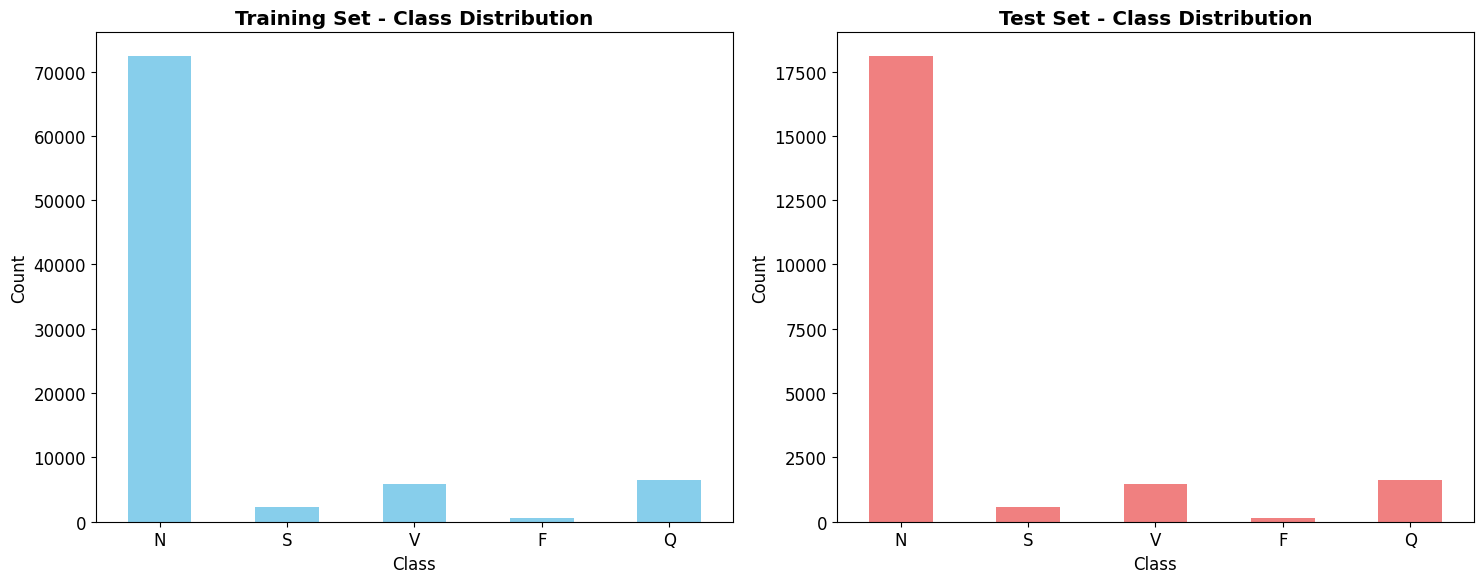

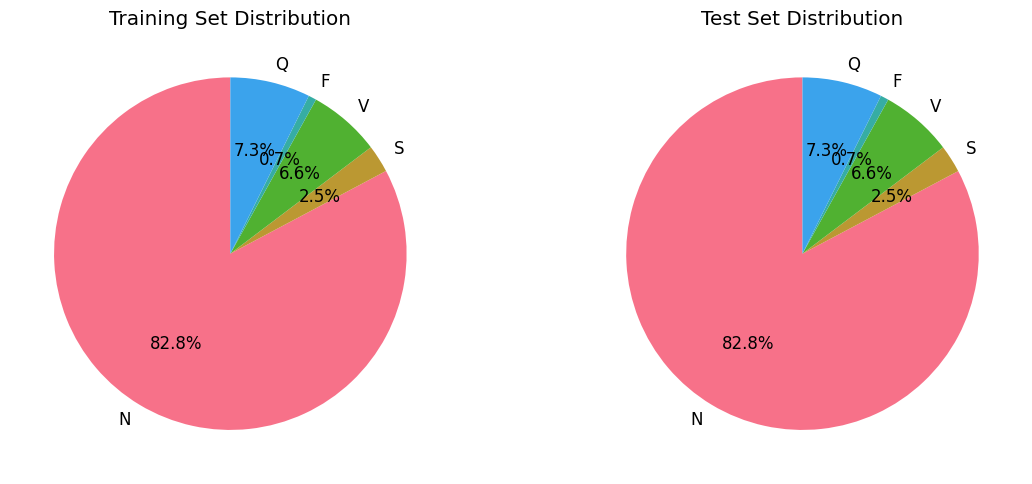

In [8]:
# VISUALIZE CLASS DISTRIBUTIONS
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training distribution
train_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Training Set - Class Distribution', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Add class names to x-axis
class_labels = [Config.CLASS_NAMES_SHORT[i] for i in train_counts.index]
axes[0].set_xticklabels(class_labels)

# Test distribution
test_counts.plot(kind='bar', ax=axes[1], color='lightcoral')
axes[1].set_title('Test Set - Class Distribution', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)

class_labels_test = [Config.CLASS_NAMES_SHORT[i] for i in test_counts.index]
axes[1].set_xticklabels(class_labels_test)

plt.tight_layout()
plt.show()

# Class distribution pie chart
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.pie(train_counts.values, labels=[Config.CLASS_NAMES_SHORT[i] for i in train_counts.index],
        autopct='%1.1f%%', startangle=90)
plt.title('Training Set Distribution')

plt.subplot(1, 2, 2)
plt.pie(test_counts.values, labels=[Config.CLASS_NAMES_SHORT[i] for i in test_counts.index],
        autopct='%1.1f%%', startangle=90)
plt.title('Test Set Distribution')

plt.tight_layout()
plt.show()

ECG SIGNAL VISUALIZATION


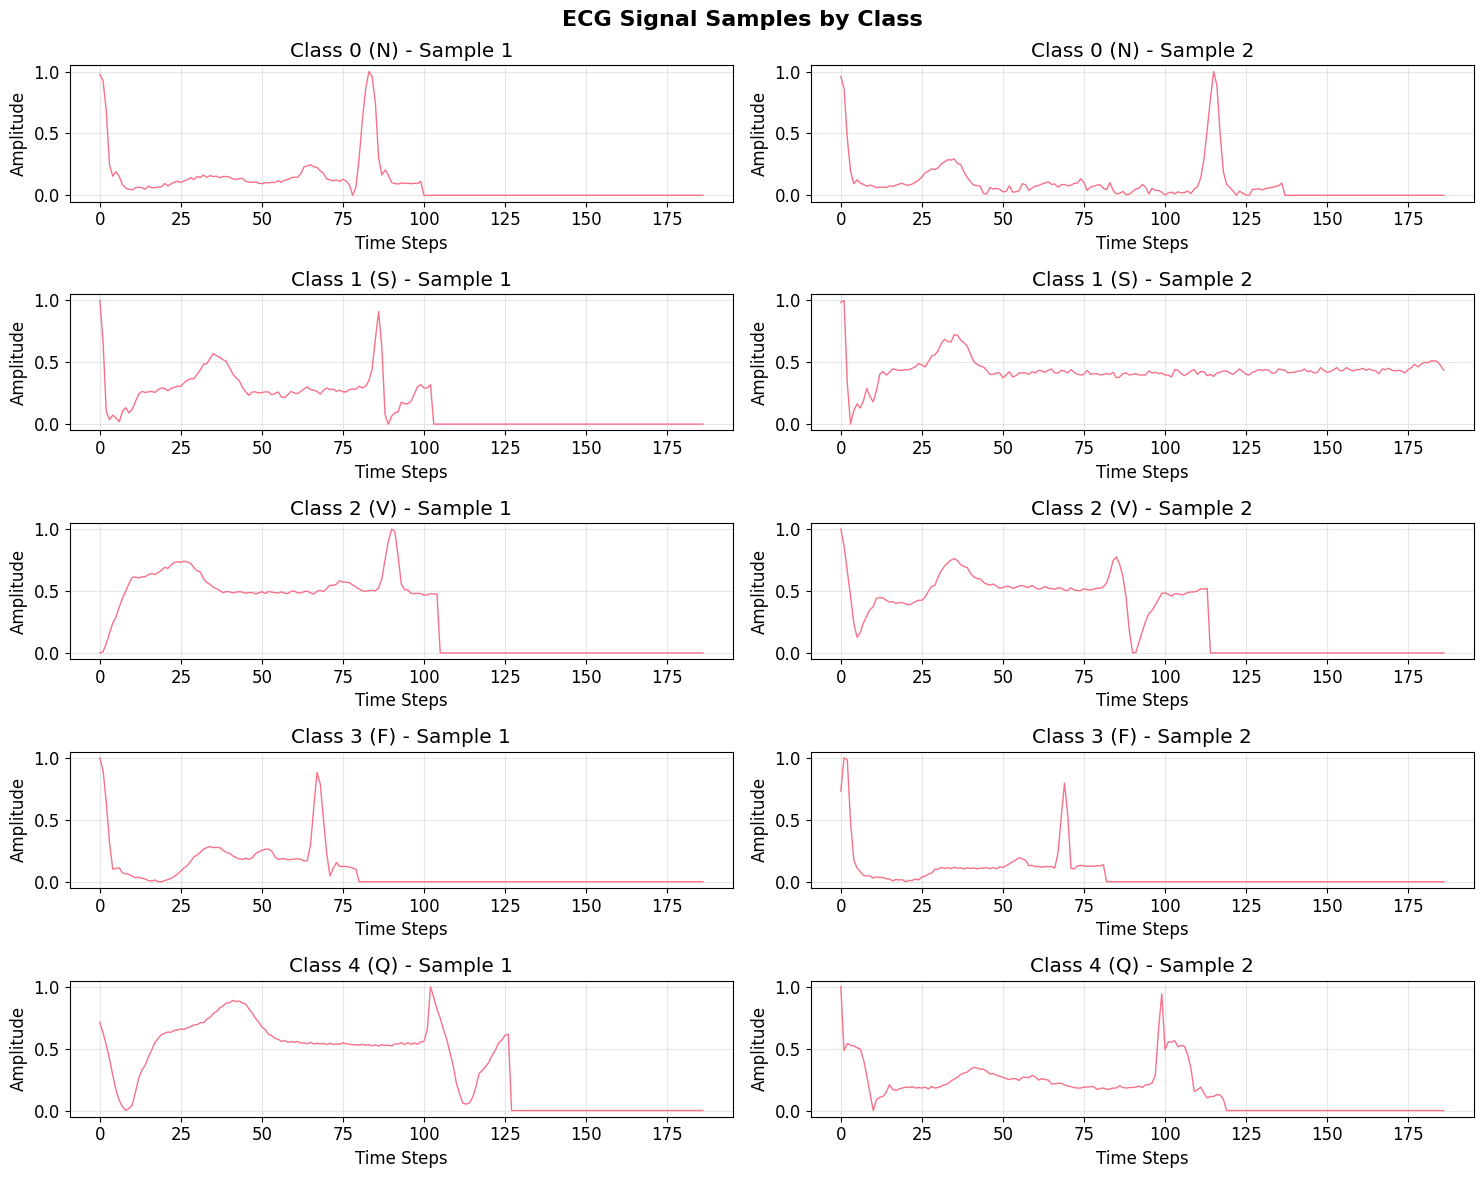


SIGNAL STATISTICS:
Class 0 (N):
  Mean amplitude: 0.1619
  Std amplitude:  0.1678
  Signal range:   0.9142

Class 1 (S):
  Mean amplitude: 0.1948
  Std amplitude:  0.1616
  Signal range:   0.8596

Class 2 (V):
  Mean amplitude: 0.2438
  Std amplitude:  0.2125
  Signal range:   0.5912

Class 3 (F):
  Mean amplitude: 0.1073
  Std amplitude:  0.1071
  Signal range:   0.9249

Class 4 (Q):
  Mean amplitude: 0.2509
  Std amplitude:  0.1341
  Signal range:   0.8600



In [9]:
# VISUALIZE ECG SIGNALS
print("ECG SIGNAL VISUALIZATION")
print("=" * 40)

# Plot sample signals for each class
fig, axes = plt.subplots(Config.N_CLASSES, 2, figsize=(15, 12))
fig.suptitle('ECG Signal Samples by Class', fontsize=16, fontweight='bold')

for class_idx in range(Config.N_CLASSES):
    # Get samples from this class
    class_mask = y_train_raw == class_idx
    class_samples = X_train[class_mask]

    if len(class_samples) > 0:
        # Plot 2 different samples
        for sample_idx in range(min(2, len(class_samples))):
            signal = class_samples[sample_idx]
            axes[class_idx, sample_idx].plot(signal, linewidth=1)
            axes[class_idx, sample_idx].set_title(
                f'Class {class_idx} ({Config.CLASS_NAMES_SHORT[class_idx]}) - Sample {sample_idx+1}'
            )
            axes[class_idx, sample_idx].set_xlabel('Time Steps')
            axes[class_idx, sample_idx].set_ylabel('Amplitude')
            axes[class_idx, sample_idx].grid(True, alpha=0.3)
    else:
        # No samples for this class
        for sample_idx in range(2):
            axes[class_idx, sample_idx].text(0.5, 0.5, 'No samples',
                                            transform=axes[class_idx, sample_idx].transAxes,
                                            ha='center', va='center')

plt.tight_layout()
plt.show()

# Signal statistics
print("\nSIGNAL STATISTICS:")
for class_idx in range(Config.N_CLASSES):
    class_mask = y_train_raw == class_idx
    class_samples = X_train[class_mask]

    if len(class_samples) > 0:
        mean_signal = np.mean(class_samples, axis=0)
        std_signal = np.std(class_samples, axis=0)

        print(f"Class {class_idx} ({Config.CLASS_NAMES_SHORT[class_idx]}):")
        print(f"  Mean amplitude: {np.mean(mean_signal):.4f}")
        print(f"  Std amplitude:  {np.mean(std_signal):.4f}")
        print(f"  Signal range:   {np.ptp(mean_signal):.4f}")
        print()

# ECG Heartbeat Classification - Part 3: Preprocessing & SMOTE

## Part 3 Overview:
- Data preprocessing and scaling
- SMOTE balancing (50,000 samples per class)
- Data preparation for different models
- Memory monitoring

In [10]:
# DATA PREPROCESSING
print("DATA PREPROCESSING")
print("=" * 40)

# Standardize features
print("Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training data - Mean: {np.mean(X_train_scaled):.6f}, Std: {np.std(X_train_scaled):.6f}")
print(f"Test data - Mean: {np.mean(X_test_scaled):.6f}, Std: {np.std(X_test_scaled):.6f}")

# Update global variables
X_train = X_train_scaled
X_test = X_test_scaled

print("Standardization completed!")
memory_info()

DATA PREPROCESSING
Standardizing features...
Training data - Mean: -0.000000, Std: 1.000000
Test data - Mean: -0.004837, Std: 0.994551
Standardization completed!
Memory: 21.6% used (2.4GB / 12.7GB)


In [11]:
# SMOTE BALANCING
print("\nSMOTE BALANCING")
print("=" * 40)

from collections import Counter

print("\nCAPPING DOMINANT CLASS AND APPLYING SMOTE")
print("=" * 40)

# Step 1: Cap class 0 at 50,000
cap_class = 0
cap_limit = Config.SMOTE_TARGET_SAMPLES

class_0_mask = y_train_raw == cap_class
class_0_indices = np.where(class_0_mask)[0]
np.random.seed(Config.RANDOM_SEED)
selected_class_0_indices = np.random.choice(class_0_indices, cap_limit, replace=False)

# Combine with all other classes
other_indices = np.where(y_train_raw != cap_class)[0]
combined_indices = np.concatenate([selected_class_0_indices, other_indices])

# Subset the data
X_train_capped = X_train[combined_indices]
y_train_capped = y_train_raw[combined_indices]

print(f"After capping class 0: {Counter(y_train_capped)}")

# Step 2: Apply SMOTE to bring each class up to 50,000
print(f"\nApplying SMOTE (target: {Config.SMOTE_TARGET_SAMPLES:,} per class)...")
smote = SMOTE(
    sampling_strategy={i: Config.SMOTE_TARGET_SAMPLES for i in range(Config.N_CLASSES)},
    random_state=Config.RANDOM_SEED
)

X_train_smote, y_train_raw_smote = smote.fit_resample(X_train_capped, y_train_capped)

print("After SMOTE:")
for cls, count in sorted(Counter(y_train_raw_smote).items()):
    print(f"  Class {cls}: {count:,} samples")

print(f"\nTotal training samples after SMOTE: {len(X_train_smote):,}")
print(f"SMOTE expansion ratio: {len(X_train_smote) / len(X_train):.2f}x")

memory_info()



SMOTE BALANCING

CAPPING DOMINANT CLASS AND APPLYING SMOTE
After capping class 0: Counter({np.int64(0): 50000, np.int64(4): 6431, np.int64(2): 5788, np.int64(1): 2223, np.int64(3): 641})

Applying SMOTE (target: 50,000 per class)...
After SMOTE:
  Class 0: 50,000 samples
  Class 1: 50,000 samples
  Class 2: 50,000 samples
  Class 3: 50,000 samples
  Class 4: 50,000 samples

Total training samples after SMOTE: 250,000
SMOTE expansion ratio: 2.86x
Memory: 23.8% used (2.7GB / 12.7GB)


In [12]:
# PREPARE DATA FOR DIFFERENT MODELS
print("\nPREPARING DATA FORMATS")
print("=" * 40)

# For CNN models - reshape and categorical encoding
print("Preparing CNN format...")
X_train_cnn_smote = X_train_smote.reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Categorical encoding for labels
y_train_cat_smote = to_categorical(y_train_raw_smote, Config.N_CLASSES)
y_test_cat = to_categorical(y_test_raw, Config.N_CLASSES)

print(f"CNN training data shape: {X_train_cnn_smote.shape}")
print(f"CNN test data shape: {X_test_cnn.shape}")
print(f"Categorical training labels shape: {y_train_cat_smote.shape}")
print(f"Categorical test labels shape: {y_test_cat.shape}")

# Verify data integrity
print("\nDATA INTEGRITY CHECK:")
print(f"Training features range: [{np.min(X_train_smote):.4f}, {np.max(X_train_smote):.4f}]")
print(f"Test features range: [{np.min(X_test):.4f}, {np.max(X_test):.4f}]")
print(f"Training labels unique: {np.unique(y_train_raw_smote)}")
print(f"Test labels unique: {np.unique(y_test_raw)}")

memory_info()


PREPARING DATA FORMATS
Preparing CNN format...
CNN training data shape: (250000, 187, 1)
CNN test data shape: (21892, 187, 1)
Categorical training labels shape: (250000, 5)
Categorical test labels shape: (21892, 5)

DATA INTEGRITY CHECK:
Training features range: [-3.6959, 31.2370]
Test features range: [-3.6959, 31.2370]
Training labels unique: [0 1 2 3 4]
Test labels unique: [0 1 2 3 4]
Memory: 23.6% used (2.7GB / 12.7GB)



VISUALIZING SMOTE EFFECT


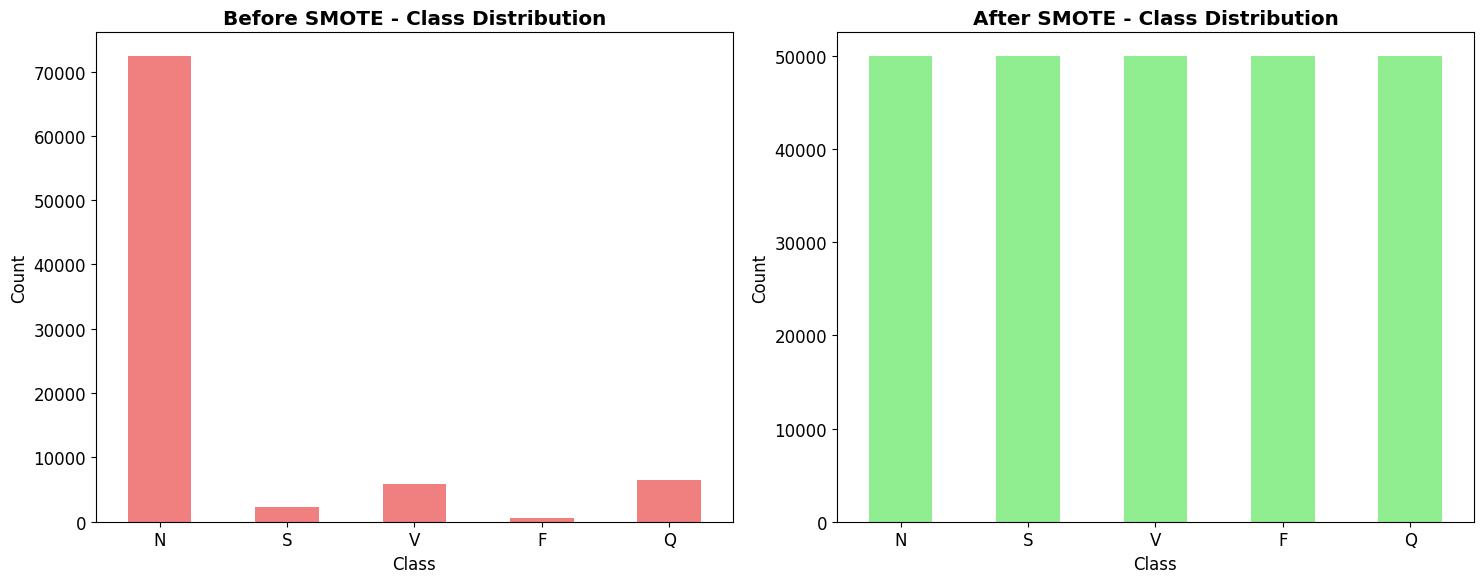


SMOTE STATISTICS:
Original training samples: 87,554
SMOTE training samples: 250,000
Samples added: 162,446
Data increase: 185.5%
Class 0 (N): 72,471 → 50,000 (+-22,471)
Class 1 (S): 2,223 → 50,000 (+47,777)
Class 2 (V): 5,788 → 50,000 (+44,212)
Class 3 (F): 641 → 50,000 (+49,359)
Class 4 (Q): 6,431 → 50,000 (+43,569)


In [13]:
# VISUALIZE SMOTE EFFECT
print("\nVISUALIZING SMOTE EFFECT")
print("=" * 40)

# Before and after SMOTE comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before SMOTE
before_counts = pd.Series(y_train_raw).value_counts().sort_index()
before_counts.plot(kind='bar', ax=axes[0], color='lightcoral')
axes[0].set_title('Before SMOTE - Class Distribution', fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
class_labels = [Config.CLASS_NAMES_SHORT[i] for i in before_counts.index]
axes[0].set_xticklabels(class_labels)

# After SMOTE
after_counts = pd.Series(y_train_raw_smote).value_counts().sort_index()
after_counts.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('After SMOTE - Class Distribution', fontweight='bold')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)
class_labels = [Config.CLASS_NAMES_SHORT[i] for i in after_counts.index]
axes[1].set_xticklabels(class_labels)

plt.tight_layout()
plt.show()

# SMOTE statistics
print("\nSMOTE STATISTICS:")
print(f"Original training samples: {len(y_train_raw):,}")
print(f"SMOTE training samples: {len(y_train_raw_smote):,}")
print(f"Samples added: {len(y_train_raw_smote) - len(y_train_raw):,}")
print(f"Data increase: {((len(y_train_raw_smote) / len(y_train_raw)) - 1) * 100:.1f}%")

for class_idx in range(Config.N_CLASSES):
    original_count = np.sum(y_train_raw == class_idx)
    smote_count = np.sum(y_train_raw_smote == class_idx)
    added = smote_count - original_count
    print(f"Class {class_idx} ({Config.CLASS_NAMES_SHORT[class_idx]}): {original_count:,} → {smote_count:,} (+{added:,})")

In [14]:
# FINAL DATA SUMMARY
print("\nFINAL DATA SUMMARY")
print("=" * 50)

print("TRAINING DATA (After SMOTE):")
print(f"  Features shape: {X_train_smote.shape}")
print(f"  Labels shape: {y_train_raw_smote.shape}")
print(f"  CNN features shape: {X_train_cnn_smote.shape}")
print(f"  CNN labels shape: {y_train_cat_smote.shape}")

print("\nTEST DATA (Original):")
print(f"  Features shape: {X_test.shape}")
print(f"  Labels shape: {y_test_raw.shape}")
print(f"  CNN features shape: {X_test_cnn.shape}")
print(f"  CNN labels shape: {y_test_cat.shape}")

print("\nDATA CHARACTERISTICS:")
print(f"  Feature range: [{np.min(X_train_smote):.4f}, {np.max(X_train_smote):.4f}]")
print(f"  Classes: {Config.N_CLASSES}")
print(f"  Samples per class (training): {Config.SMOTE_TARGET_SAMPLES:,}")
print(f"  Total training samples: {len(X_train_smote):,}")
print(f"  Total test samples: {len(X_test):,}")

print("\nPreprocessing completed successfully!")
print("Ready for model training...")
memory_info()


FINAL DATA SUMMARY
TRAINING DATA (After SMOTE):
  Features shape: (250000, 187)
  Labels shape: (250000,)
  CNN features shape: (250000, 187, 1)
  CNN labels shape: (250000, 5)

TEST DATA (Original):
  Features shape: (21892, 187)
  Labels shape: (21892,)
  CNN features shape: (21892, 187, 1)
  CNN labels shape: (21892, 5)

DATA CHARACTERISTICS:
  Feature range: [-3.6959, 31.2370]
  Classes: 5
  Samples per class (training): 50,000
  Total training samples: 250,000
  Total test samples: 21,892

Preprocessing completed successfully!
Ready for model training...
Memory: 23.6% used (2.7GB / 12.7GB)


# ECG Heartbeat Classification - Part 4: XGBoost with Feature Engineering

## Part 4 Overview:
- XGBoost baseline (original features only)
- Advanced feature engineering (statistical, temporal, frequency domain)
- XGBoost with engineered features
- XGBoost with engineered features + SMOTE
- Performance comparison and feature importance analysis

In [15]:
# ADVANCED FEATURE ENGINEERING FUNCTIONS

def extract_advanced_features(X_data):
    """Extract comprehensive features from ECG signals"""
    print("Extracting advanced features...")

    features_list = []

    for i, signal in enumerate(X_data):
        if i % 10000 == 0:
            print(f"   Processing sample {i}/{len(X_data)}")

        signal_features = {}

        # STATISTICAL FEATURES
        signal_features['mean'] = np.mean(signal)
        signal_features['std'] = np.std(signal)
        signal_features['var'] = np.var(signal)
        signal_features['skewness'] = stats.skew(signal)
        signal_features['kurtosis'] = stats.kurtosis(signal)
        signal_features['median'] = np.median(signal)
        signal_features['mad'] = stats.median_abs_deviation(signal)
        signal_features['iqr'] = np.percentile(signal, 75) - np.percentile(signal, 25)
        signal_features['range'] = np.max(signal) - np.min(signal)

        # AMPLITUDE FEATURES
        signal_features['max_amp'] = np.max(signal)
        signal_features['min_amp'] = np.min(signal)
        signal_features['peak_to_peak'] = signal_features['max_amp'] - signal_features['min_amp']
        signal_features['rms'] = np.sqrt(np.mean(signal**2))

        # PEAK DETECTION FEATURES
        peaks, _ = find_peaks(signal, height=np.mean(signal) + 0.5*np.std(signal))
        signal_features['num_peaks'] = len(peaks)
        signal_features['avg_peak_height'] = np.mean(signal[peaks]) if len(peaks) > 0 else 0
        signal_features['peak_prominence'] = np.mean(peak_prominences(signal, peaks)[0]) if len(peaks) > 0 else 0

        # TEMPORAL FEATURES
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks)
            signal_features['avg_rr_interval'] = np.mean(rr_intervals)
            signal_features['std_rr_interval'] = np.std(rr_intervals)
            signal_features['rr_irregularity'] = np.std(rr_intervals) / np.mean(rr_intervals) if np.mean(rr_intervals) > 0 else 0
        else:
            signal_features['avg_rr_interval'] = 0
            signal_features['std_rr_interval'] = 0
            signal_features['rr_irregularity'] = 0

        # FREQUENCY DOMAIN FEATURES (FFT)
        fft_vals = np.fft.fft(signal)
        fft_magnitude = np.abs(fft_vals[:len(signal)//2])
        freqs = np.fft.fftfreq(len(signal), 1.0)[:len(signal)//2]

        if np.sum(fft_magnitude) > 0:
            signal_features['spectral_centroid'] = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
            cumsum_fft = np.cumsum(fft_magnitude)
            rolloff_idx = np.where(cumsum_fft >= 0.85 * np.sum(fft_magnitude))[0]
            signal_features['spectral_rolloff'] = freqs[rolloff_idx[0]] if len(rolloff_idx) > 0 else 0
            signal_features['spectral_bandwidth'] = np.sqrt(np.sum(((freqs - signal_features['spectral_centroid'])**2) * fft_magnitude) / np.sum(fft_magnitude))
        else:
            signal_features['spectral_centroid'] = 0
            signal_features['spectral_rolloff'] = 0
            signal_features['spectral_bandwidth'] = 0

        # FREQUENCY BANDS POWER
        low_freq = (freqs >= 0.04) & (freqs <= 0.15)
        mid_freq = (freqs > 0.15) & (freqs <= 0.4)
        high_freq = (freqs > 0.4) & (freqs <= 2.0)

        signal_features['low_freq_power'] = np.sum(fft_magnitude[low_freq])
        signal_features['mid_freq_power'] = np.sum(fft_magnitude[mid_freq])
        signal_features['high_freq_power'] = np.sum(fft_magnitude[high_freq])
        signal_features['total_power'] = np.sum(fft_magnitude)

        # MORPHOLOGICAL FEATURES
        first_diff = np.diff(signal)
        second_diff = np.diff(first_diff)

        signal_features['first_diff_mean'] = np.mean(first_diff)
        signal_features['first_diff_std'] = np.std(first_diff)
        signal_features['second_diff_mean'] = np.mean(second_diff)
        signal_features['second_diff_std'] = np.std(second_diff)

        # Zero crossing rate
        zero_crossings = np.where(np.diff(np.sign(signal - np.mean(signal))))[0]
        signal_features['zero_crossing_rate'] = len(zero_crossings) / len(signal)

        # ENTROPY FEATURES
        try:
            signal_features['approx_entropy'] = antropy.app_entropy(signal, m=2, r=0.2*np.std(signal))
            signal_features['sample_entropy'] = antropy.sample_entropy(signal, m=2, r=0.2*np.std(signal))
        except:
            signal_features['approx_entropy'] = 0
            signal_features['sample_entropy'] = 0

        # WAVELET FEATURES
        try:
            coeffs = pywt.wavedec(signal, 'db4', level=4)
            for i, coeff in enumerate(coeffs):
                signal_features[f'wavelet_energy_level_{i}'] = np.sum(coeff**2)
                signal_features[f'wavelet_std_level_{i}'] = np.std(coeff)
        except:
            for i in range(5):
                signal_features[f'wavelet_energy_level_{i}'] = 0
                signal_features[f'wavelet_std_level_{i}'] = 0

        features_list.append(signal_features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)

    print(f"Feature engineering completed!")
    print(f"   XGB Original features: {X_data.shape[1]}")
    print(f"   XGB + Engineered features: {features_df.shape[1]}")
    print(f"   Total features: {X_data.shape[1] + features_df.shape[1]}")

    return features_df

print("Feature engineering functions loaded!")

Feature engineering functions loaded!


In [16]:
from collections import Counter

def cap_and_smote(X, y,
                  cap_class=0,
                  cap_limit=Config.SMOTE_TARGET_SAMPLES,
                  target_per_class=Config.SMOTE_TARGET_SAMPLES,
                  random_seed=Config.RANDOM_SEED):
    """Trim class 0 down to cap_limit, then SMOTE up all classes to target_per_class."""
    np.random.seed(random_seed)
    # 1) cap class 0
    idx0 = np.where(y == cap_class)[0]
    chosen0 = np.random.choice(idx0, cap_limit, replace=False)
    others = np.where(y != cap_class)[0]
    idx = np.concatenate([chosen0, others])
    Xc, yc = X[idx], y[idx]
    print("After capping:", dict(Counter(yc)))
    # 2) SMOTE up to target_per_class
    sm = SMOTE(
      sampling_strategy={i: target_per_class for i in range(Config.N_CLASSES)},
      random_state=random_seed
    )
    Xs, ys = sm.fit_resample(Xc, yc)
    print("After SMOTE:", dict(Counter(ys)))
    return Xs, ys


In [17]:
# EXPERIMENT 1: XGBoost with Original Features Only
print("EXPERIMENT 1: XGBoost - Original Features Only")
print("=" * 60)

from sklearn.metrics import classification_report

def train_xgboost_variant(X_train, y_train, X_test, y_test,
                          variant_name, use_smote=False):
    print(f"\n▶️ Training XGBoost - {variant_name}")
    print(f"   SMOTE: {'Yes' if use_smote else 'No'}")
    start_time = time.time()

    # 1) cap & SMOTE if requested
    if use_smote:
        X_train_proc, y_train_proc = cap_and_smote(X_train, y_train)
    else:
        X_train_proc, y_train_proc = X_train, y_train

    # 2) train
    model = XGBClassifier(
        n_estimators=200, max_depth=8, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        random_state=Config.RANDOM_SEED,
        eval_metric='mlogloss', n_jobs=-1
    )
    model.fit(X_train_proc, y_train_proc)
    training_time = time.time() - start_time

    # 3) predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # 4) compute metrics
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1        = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # 5) print classification_report table
    report = classification_report(y_test, y_pred,
                                   output_dict=True, zero_division=0)
    df = pd.DataFrame(report).T.loc[
        [str(i) for i in range(Config.N_CLASSES)] + ['macro avg','weighted avg'],
        ['precision','recall','f1-score','support']
    ]
    print("\n📋 Classification Report:")
    display(df.style.format({
        'precision':'{:.3f}',
        'recall':'{:.3f}',
        'f1-score':'{:.3f}',
        'support':'{:.0f}'
    }))


    # ───────────────────────────────────────────
    #   SAVE XGBOOST MODEL
    # ───────────────────────────────────────────
    model_path = os.path.join(
        BASE_MODEL_DIR,
        'xgboost',
        f"xgb_{variant_name.replace(' ', '_')}.json"
    )
    model.save_model(model_path)
    models_trained[variant_name] = model_path

    # 6) return all expected keys
    return {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'variant_name': variant_name,
        'features_used': X_train.shape[1],
        'smote_applied': use_smote
    }




memory_info()

EXPERIMENT 1: XGBoost - Original Features Only
Memory: 23.6% used (2.7GB / 12.7GB)


In [18]:
# EXPERIMENT 1: XGBoost with Original Features Only

# Train XGBoost with original features only
xgb_results = {}
xgb_results['XGB_Original'] = train_xgboost_variant(
    X_train_smote, y_train_raw_smote, X_test, y_test_raw,
    "Original Features", use_smote=False
)


▶️ Training XGBoost - Original Features
   SMOTE: No

📋 Classification Report:


,precision,recall,f1-score,support
0,0.989,0.983,0.986,18118
1,0.710,0.802,0.753,556
2,0.945,0.948,0.946,1448
3,0.685,0.833,0.752,162
4,0.981,0.981,0.981,1608
macro avg,0.862,0.909,0.884,21892
weighted avg,0.977,0.975,0.976,21892


In [19]:
# EXTRACT ENGINEERED FEATURES
print("\nEXTRACTING ENGINEERED FEATURES")
print("=" * 50)

# Extract features for training set
print("Extracting engineered features for training set...")
train_engineered_features = extract_advanced_features(X_train)
memory_info()

# Extract features for test set
print("\nExtracting engineered features for test set...")
test_engineered_features = extract_advanced_features(X_test)
memory_info()

# Combine original + engineered features
print("\nCombining original and engineered features...")
X_train_combined = np.hstack([X_train, train_engineered_features.values])
X_test_combined = np.hstack([X_test, test_engineered_features.values])

print(f"Combined training features shape: {X_train_combined.shape}")
print(f"Combined test features shape: {X_test_combined.shape}")

# Display feature categories
print("\nFEATURE CATEGORIES:")
feature_names = list(train_engineered_features.columns)
categories = {
    'Statistical': ['mean', 'std', 'var', 'skewness', 'kurtosis', 'median', 'mad', 'iqr', 'range'],
    'Amplitude': ['max_amp', 'min_amp', 'peak_to_peak', 'rms'],
    'Peak': ['num_peaks', 'avg_peak_height', 'peak_prominence'],
    'Temporal': ['avg_rr_interval', 'std_rr_interval', 'rr_irregularity'],
    'Frequency': ['spectral_centroid', 'spectral_rolloff', 'spectral_bandwidth', 'low_freq_power', 'mid_freq_power', 'high_freq_power', 'total_power'],
    'Morphological': ['first_diff_mean', 'first_diff_std', 'second_diff_mean', 'second_diff_std', 'zero_crossing_rate'],
    'Entropy': ['approx_entropy', 'sample_entropy'],
    'Wavelet': [f for f in feature_names if 'wavelet' in f]
}

for category, features in categories.items():
    count = len([f for f in features if f in feature_names])
    print(f"  {category}: {count} features")

memory_info()


EXTRACTING ENGINEERED FEATURES
Extracting engineered features for training set...
Extracting advanced features...
   Processing sample 0/87554
   Processing sample 10000/87554
   Processing sample 20000/87554
   Processing sample 30000/87554
   Processing sample 40000/87554
   Processing sample 50000/87554
   Processing sample 60000/87554
   Processing sample 70000/87554
   Processing sample 80000/87554
Feature engineering completed!
   XGB Original features: 187
   XGB + Engineered features: 43
   Total features: 230
Memory: 28.2% used (3.3GB / 12.7GB)

Extracting engineered features for test set...
Extracting advanced features...
   Processing sample 0/21892
   Processing sample 10000/21892
   Processing sample 20000/21892
Feature engineering completed!
   XGB Original features: 187
   XGB + Engineered features: 43
   Total features: 230
Memory: 28.3% used (3.3GB / 12.7GB)

Combining original and engineered features...
Combined training features shape: (87554, 230)
Combined test fea

In [20]:
# 🚀 EXPERIMENT 2: XGBoost – Engineered Features (No SMOTE)
print("\nEXPERIMENT 2: XGB + Engineered Features (No SMOTE)")
xgb_results['XGB_Engineered'] = train_xgboost_variant(
  X_train_combined, y_train_raw, X_test_combined, y_test_raw,
  "XGB + Engineered Features", use_smote=False
)

# 🚀 EXPERIMENT 3: XGBoost – Engineered + SMOTE
print("\nEXPERIMENT 3: XGB + Engineered Features + SMOTE")
xgb_results['XGB_Engineered_SMOTE'] = train_xgboost_variant(
  X_train_combined, y_train_raw, X_test_combined, y_test_raw,
  "XGB + Engineered Features + SMOTE", use_smote=True
)

print("\n✅ All XGBoost experiments completed!")
memory_info()



EXPERIMENT 2: XGB + Engineered Features (No SMOTE)

▶️ Training XGBoost - XGB + Engineered Features
   SMOTE: No

📋 Classification Report:


,precision,recall,f1-score,support
0,0.984,0.998,0.991,18118
1,0.960,0.692,0.805,556
2,0.974,0.937,0.955,1448
3,0.869,0.735,0.796,162
4,0.997,0.976,0.986,1608
macro avg,0.957,0.868,0.907,21892
weighted avg,0.983,0.983,0.982,21892



EXPERIMENT 3: XGB + Engineered Features + SMOTE

▶️ Training XGBoost - XGB + Engineered Features + SMOTE
   SMOTE: Yes
After capping: {np.int64(0): 50000, np.int64(1): 2223, np.int64(2): 5788, np.int64(3): 641, np.int64(4): 6431}
After SMOTE: {np.int64(0): 50000, np.int64(1): 50000, np.int64(2): 50000, np.int64(3): 50000, np.int64(4): 50000}

📋 Classification Report:


,precision,recall,f1-score,support
0,0.988,0.992,0.990,18118
1,0.833,0.773,0.802,556
2,0.956,0.946,0.951,1448
3,0.794,0.833,0.813,162
4,0.992,0.982,0.987,1608
macro avg,0.913,0.905,0.909,21892
weighted avg,0.981,0.981,0.981,21892



✅ All XGBoost experiments completed!
Memory: 33.6% used (3.9GB / 12.7GB)


In [21]:
# XGBOOST VARIANTS COMPARISON
print("\nXGBOOST VARIANTS PERFORMANCE COMPARISON")
print("=" * 70)

comparison_data = []

for variant_name, result in xgb_results.items():
    comparison_data.append({
        'Variant': result['variant_name'],
        'Features': result['features_used'],
        'SMOTE': 'Yes' if result['smote_applied'] else 'No',
        'Accuracy': f"{result['accuracy']:.4f}",
        'Precision': f"{result['precision']:.4f}",
        'Recall': f"{result['recall']:.4f}",
        'F1_Score': f"{result['f1_score']:.4f}",
        'Training_Time': f"{result['training_time']:.2f}s"
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print(comparison_df.to_string(index=False))

# Highlight improvements
if len(comparison_df) >= 2:
    best_variant = comparison_df.iloc[0]
    baseline_variant = comparison_df[comparison_df['Variant'] == 'Original Features'].iloc[0]

    accuracy_improvement = float(best_variant['Accuracy']) - float(baseline_variant['Accuracy'])
    f1_improvement = float(best_variant['F1_Score']) - float(baseline_variant['F1_Score'])

    print(f"\nBEST VARIANT: {best_variant['Variant']}")
    print(f"   Accuracy improvement: +{accuracy_improvement:.4f} ({accuracy_improvement*100:.2f}%)")
    print(f"   F1-Score improvement: +{f1_improvement:.4f} ({f1_improvement*100:.2f}%)")
    print(f"   Features used: {best_variant['Features']}")
    print(f"   SMOTE applied: {best_variant['SMOTE']}")

# Store results globally
for key, result in xgb_results.items():
    results[key] = result


XGBOOST VARIANTS PERFORMANCE COMPARISON
                          Variant  Features SMOTE Accuracy Precision Recall F1_Score Training_Time
        XGB + Engineered Features       230    No   0.9829    0.9567 0.8676   0.9066       202.06s
XGB + Engineered Features + SMOTE       230   Yes   0.9815    0.9129 0.9054   0.9088       439.64s
                Original Features       187    No   0.9751    0.8621 0.9094   0.8838       360.77s

BEST VARIANT: XGB + Engineered Features
   Accuracy improvement: +0.0078 (0.78%)
   F1-Score improvement: +0.0228 (2.28%)
   Features used: 230
   SMOTE applied: No



FEATURE IMPORTANCE ANALYSIS
Analyzing feature importance for: XGB + Engineered Features

Top 20 Most Important Features:
               Feature  Importance
       ecg_feature_186    0.054778
   wavelet_std_level_0    0.033836
       ecg_feature_102    0.027432
       ecg_feature_101    0.024517
         ecg_feature_3    0.022386
         ecg_feature_4    0.021666
       first_diff_mean    0.019831
        ecg_feature_11    0.018580
        ecg_feature_36    0.017019
        ecg_feature_41    0.016813
        ecg_feature_14    0.014398
       second_diff_std    0.012867
       ecg_feature_185    0.012671
        ecg_feature_25    0.012401
       ecg_feature_100    0.011499
                 range    0.011034
       high_freq_power    0.010898
wavelet_energy_level_0    0.010635
       ecg_feature_184    0.010439
        ecg_feature_87    0.010302


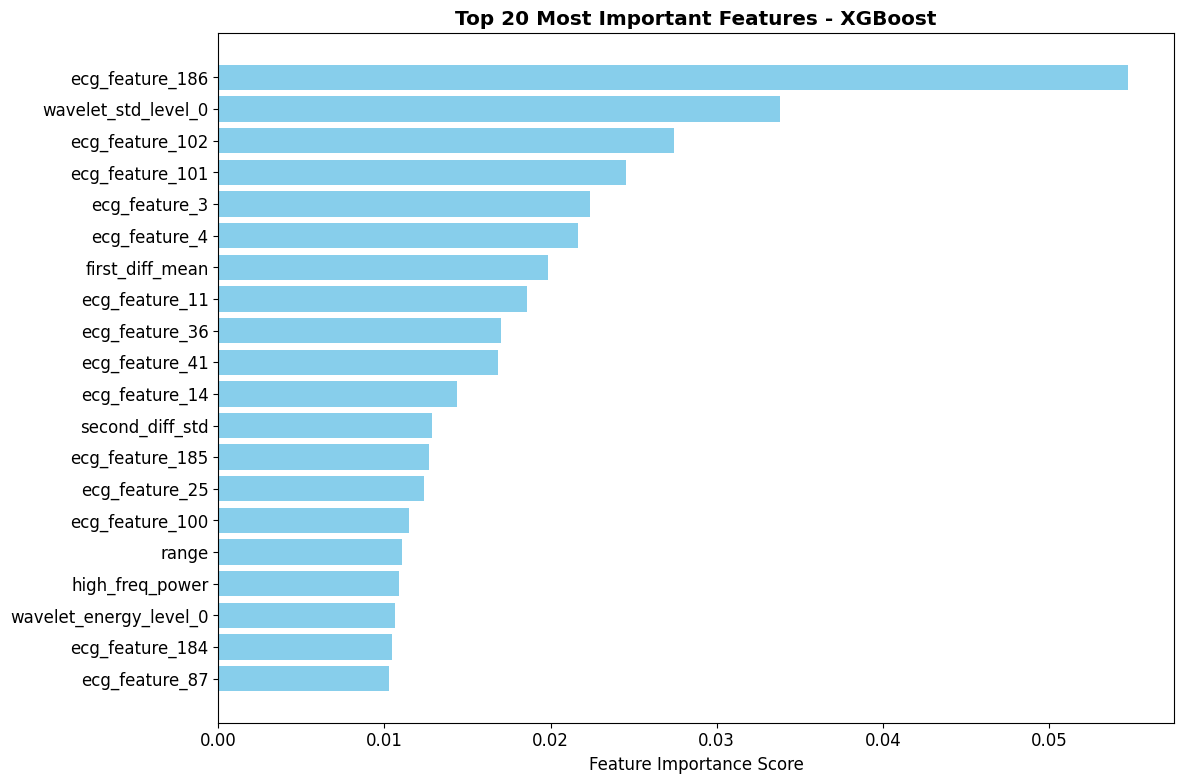


FEATURE TYPE ANALYSIS (Top 20):
   XGB + Original ECG features: 14 (70.0%)
   XGB + Engineered features: 6 (30.0%)

XGB + ENGINEERED FEATURES BY CATEGORY:
   Statistical: 4 features
   Frequency: 1 features
   Morphological: 2 features
   Wavelet: 2 features

XGBoost feature engineering analysis completed!


In [22]:
# FEATURE IMPORTANCE ANALYSIS
print("\nFEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

# Find best model
best_model_key = max(xgb_results.keys(), key=lambda k: xgb_results[k]['accuracy'])
best_model = xgb_results[best_model_key]['model']

print(f"Analyzing feature importance for: {xgb_results[best_model_key]['variant_name']}")

# Create feature names
if 'Engineered' in best_model_key:
    original_names = [f'ecg_feature_{i}' for i in range(len(Config.FEATURE_COLS))]
    engineered_names = list(train_engineered_features.columns)
    all_feature_names = original_names + engineered_names
else:
    all_feature_names = [f'ecg_feature_{i}' for i in range(len(Config.FEATURE_COLS))]

# Get feature importance
importance_scores = best_model.feature_importances_

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

# Display top features
top_n = 20
print(f"\nTop {top_n} Most Important Features:")
print(importance_df.head(top_n).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['Importance'], color='skyblue')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance Score')
plt.title(f'Top {top_n} Most Important Features - XGBoost', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Analyze feature types
if 'Engineered' in best_model_key:
    original_features = sum(1 for f in top_features['Feature'] if f.startswith('ecg_feature_'))
    engineered_features = len(top_features) - original_features

    print(f"\nFEATURE TYPE ANALYSIS (Top {top_n}):")
    print(f"   XGB + Original ECG features: {original_features} ({original_features/top_n*100:.1f}%)")
    print(f"   XGB + Engineered features: {engineered_features} ({engineered_features/top_n*100:.1f}%)")

    # Analyze engineered feature categories
    print(f"\nXGB + ENGINEERED FEATURES BY CATEGORY:")
    for category, features in categories.items():
        category_count = sum(1 for f in top_features['Feature'] if any(feat in f for feat in features))
        if category_count > 0:
            print(f"   {category}: {category_count} features")

print(f"\nXGBoost feature engineering analysis completed!")

# ECG Heartbeat Classification - Part 5: Advanced Deep Learning Models

## Part 5 Overview:
- Vision Transformer 1D (ViT-1D) for sequence modeling
- CNN + Attention + Transformer
- Performance comparison across all models

In [23]:
def train_advanced_model(model_func,
                         model_name,
                         X_train, y_train,
                         X_test,  y_test,
                         epochs=50,
                         batch_size=64):
    """Train an advanced deep learning model, save it, and return its results."""
    print(f"\nTraining {model_name}")
    print("=" * (len(model_name) + 10))

    start_time = time.time()
    # instantiate & compile
    model = model_func(X_train.shape[1:], Config.N_CLASSES)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("Model architecture:")
    print(f"   Parameters: {model.count_params():,}")
    print(f"   Train samples: {X_train.shape[0]:,}")
    print(f"   Input shape: {X_train.shape[1:]}")

    cbs = [
      tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=10, restore_best_weights=True
      ),
      tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7
      )
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cbs,
        verbose=1
    )
    training_time = time.time() - start_time

    loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    y_proba = model.predict(X_test, verbose=0)
    y_pred  = np.argmax(y_proba, axis=1)
    y_true  = np.argmax(y_test, axis=1)

    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall    = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1        = f1_score(y_true, y_pred, average='macro', zero_division=0)

    print(f"\nFinished in {training_time:.2f}s — acc: {test_acc:.4f}, f1: {f1:.4f}")

    # save
    save_path = os.path.join(BASE_MODEL_DIR, f"{model_name.replace(' ', '_')}.h5")
    model.save(save_path)
    models_trained[model_name] = save_path
    print(f"→ saved to {save_path}")

    return {
      'model': model,
      'history': history,
      'predictions': y_pred,
      'probabilities': y_proba,
      'accuracy': test_acc,
      'precision': precision,
      'recall': recall,
      'f1_score': f1,
      'training_time': training_time,
      'model_name': model_name,
      'parameters': model.count_params(),
      'epochs_trained': len(history.history['loss']),
      'save_path': save_path
    }

print("✅ Updated train_advanced_model loaded!")


✅ Updated train_advanced_model loaded!


In [24]:
# Vision Transformer 1D (ViT-1D) & RhythmNet (Attention-enhanced CNN)

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical

# --- 1) RhythmNet: Convolution + Channel Attention + Transformer Encoder ---

class ChannelAttention(layers.Layer):
    def __init__(self, filters, ratio=8):
        super().__init__()
        self.avg_pool = layers.GlobalAveragePooling1D()
        self.max_pool = layers.GlobalMaxPooling1D()
        self.shared_mlp = models.Sequential([
            layers.Dense(filters // ratio, activation="relu", kernel_initializer="he_normal", use_bias=True),
            layers.Dense(filters, kernel_initializer="he_normal", use_bias=True)
        ])
        self.sigmoid = layers.Activation("sigmoid")

    def call(self, inputs):
        # inputs: (batch, time, channels)
        avg = self.avg_pool(inputs)
        max = self.max_pool(inputs)
        # shared MLP expects 2D
        avg = self.shared_mlp(avg)
        max = self.shared_mlp(max)
        attn = self.sigmoid(avg + max)[:, None, :]    # (batch, 1, channels)
        return inputs * attn


def transformer_encoder_block(x, embed_dim, num_heads, ff_dim):
    # Multi-Head Self-Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)(x, x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
    # Feed-Forward
    ffn_output = layers.Dense(ff_dim, activation="relu")(x)
    ffn_output = layers.Dense(embed_dim)(ffn_output)
    return layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)


def create_rhythmnet(input_shape=(300,1), num_classes=5):
    inputs = layers.Input(shape=input_shape)   # (300,1)
    x = layers.Conv1D(16, 21, padding="same", activation="relu")(inputs)
    x = ChannelAttention(16)(x)
    x = layers.MaxPool1D(3, strides=2, padding="same")(x)

    x = layers.Conv1D(32, 23, padding="same", activation="relu")(x)
    x = ChannelAttention(32)(x)
    x = layers.MaxPool1D(3, strides=2, padding="same")(x)

    x = layers.Conv1D(64, 25, padding="same", activation="relu")(x)
    x = ChannelAttention(64)(x)
    x = layers.AveragePooling1D(3, strides=2, padding="same")(x)

    x = layers.Conv1D(128, 27, padding="same", activation="relu")(x)
    x = ChannelAttention(128)(x)

    # Transformer encoder
    x = transformer_encoder_block(x, embed_dim=128, num_heads=4, ff_dim=256)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="Rhythm_Net")
    return model


# --- 2) ViT-1D: Vision Transformer adapted to 1D ECG ---

def create_vit1d(input_shape=(187,1), num_classes=5,
                 patch_size=16, embed_dim=64, num_heads=4, num_layers=4, mlp_dim=128):
    inputs = layers.Input(shape=input_shape)
    # Patch embedding
    x = layers.Conv1D(embed_dim, patch_size, strides=patch_size, padding="same")(inputs)
    x = layers.Reshape((-1, embed_dim))(x)
    # Positional encoding
    seq_len = x.shape[1]
    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_emb = layers.Embedding(input_dim=seq_len, output_dim=embed_dim)(positions)
    x = x + pos_emb

    # Transformer blocks
    for _ in range(num_layers):
        attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_out)
        # MLP
        mlp_out = layers.Dense(mlp_dim, activation="relu")(x)
        mlp_out = layers.Dense(embed_dim)(mlp_out)
        x = layers.LayerNormalization(epsilon=1e-6)(x + mlp_out)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs, name="ViT1D")
    return model


epochs = 30
batch_size = 128


In [25]:
# TRAIN VISION TRANSFORMER 1D
print("TRAINING ADVANCED DEEP LEARNING MODELS")
print("=" * 50)

# Initialize results storage
advanced_results = {}

# Vision Transformer
vit_res = train_advanced_model(
    create_vit1d, "Vision Transformer 1D",
    X_train_cnn_smote, y_train_cat_smote,
    X_test_cnn,       y_test_cat,
    epochs=epochs, batch_size=batch_size
)
advanced_results['ViT1D'] = vit_res


TRAINING ADVANCED DEEP LEARNING MODELS

Training Vision Transformer 1D
Model architecture:
   Parameters: 135,301
   Train samples: 250,000
   Input shape: (187, 1)
Epoch 1/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.8247 - loss: 0.4730 - val_accuracy: 0.9460 - val_loss: 0.1689 - learning_rate: 0.0010
Epoch 2/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9599 - loss: 0.1175 - val_accuracy: 0.9397 - val_loss: 0.1827 - learning_rate: 0.0010
Epoch 3/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9705 - loss: 0.0901 - val_accuracy: 0.9480 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 4/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9762 - loss: 0.0716 - val_accuracy: 0.9471 - val_loss: 0.1578 - learning_rate: 0.0010
Epoch 5/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9800 - loss: 0.0618 - val_accuracy: 0.9509 - val_loss: 0.1526 - learning_rate: 0.0010
Epoch 6/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - ac


Finished in 592.44s — acc: 0.9808, f1: 0.9073
→ saved to /content/drive/MyDrive/models/Vision_Transformer_1D.h5


In [26]:

# RhythmNet
rhythm_res = train_advanced_model(
    create_rhythmnet, "RhythmNet",
    X_train_cnn_smote, y_train_cat_smote,
    X_test_cnn,       y_test_cat,
    epochs=epochs, batch_size=batch_size
)
advanced_results['RhythmNet'] = rhythm_res


Training RhythmNet
Model architecture:
   Parameters: 440,083
   Train samples: 250,000
   Input shape: (187, 1)
Epoch 1/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - accuracy: 0.8220 - loss: 0.4706 - val_accuracy: 0.9482 - val_loss: 0.1463 - learning_rate: 0.0010
Epoch 2/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.9683 - loss: 0.0934 - val_accuracy: 0.9555 - val_loss: 0.1266 - learning_rate: 0.0010
Epoch 3/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9805 - loss: 0.0582 - val_accuracy: 0.9637 - val_loss: 0.1101 - learning_rate: 0.0010
Epoch 4/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9863 - loss: 0.0430 - val_accuracy: 0.9666 - val_loss: 0.1108 - learning_rate: 0.0010
Epoch 5/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9891 - loss: 0.0335 - val_accuracy: 0.9734 - val_loss: 0.1085 - learning_rate: 0.0010
Epoch 6/30
1954/1954 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9914 - loss: 0.0267 - val_accuracy: 0.967


Finished in 582.75s — acc: 0.9857, f1: 0.9217
→ saved to /content/drive/MyDrive/models/RhythmNet.h5



TRAINING CURVES VISUALIZATION


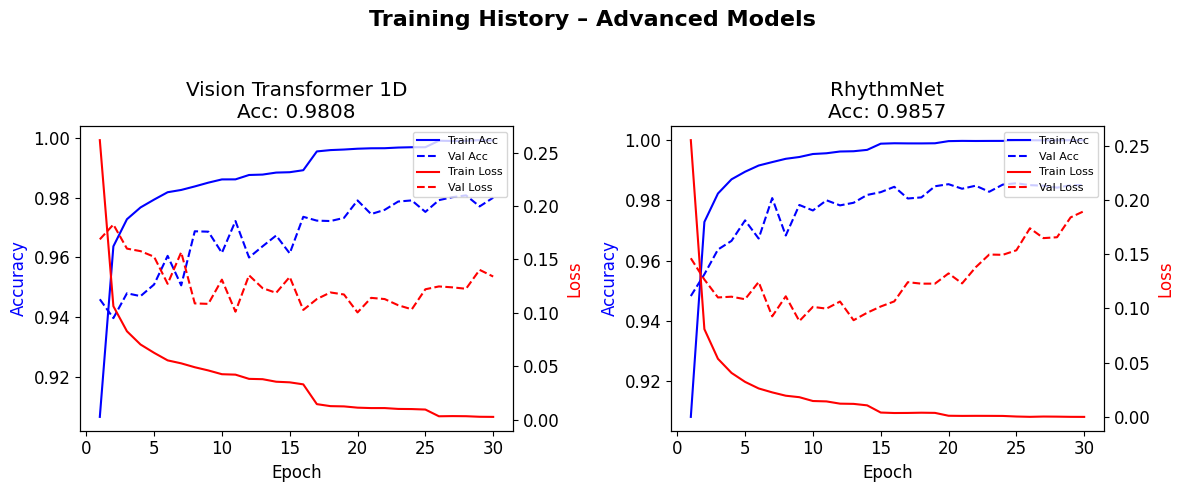

Training curves visualization completed!


In [27]:
# VISUALIZE TRAINING CURVES
print("\nTRAINING CURVES VISUALIZATION")
print("=" * 40)

n_models = len(advanced_results)
fig, axes = plt.subplots(1, n_models, figsize=(6 * n_models, 5), squeeze=False)
fig.suptitle('Training History – Advanced Models', fontsize=16, fontweight='bold')

for idx, (model_key, result) in enumerate(advanced_results.items()):
    ax = axes[0, idx]
    hist = result['history'].history
    epochs = range(1, len(hist['loss']) + 1)

    # twin axis for loss
    ax2 = ax.twinx()

    # accuracy curves
    ax.plot(epochs, hist['accuracy'], 'b-',  label='Train Acc')
    ax.plot(epochs, hist['val_accuracy'], 'b--', label='Val Acc')
    # loss curves
    ax2.plot(epochs, hist['loss'], 'r-',  label='Train Loss')
    ax2.plot(epochs, hist['val_loss'], 'r--', label='Val Loss')

    ax.set_title(f"{result['model_name']}\nAcc: {result['accuracy']:.4f}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy', color='b')
    ax2.set_ylabel('Loss', color='r')

    # combined legend
    lines, labels = ax.get_legend_handles_labels()
    l2, l2_labels = ax2.get_legend_handles_labels()
    ax.legend(lines + l2, labels + l2_labels, loc='upper right', fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("Training curves visualization completed!")


# ECG Heartbeat Classification - Part 6: Comprehensive Evaluation

## Part 6 Overview:
- Detailed confusion matrices for all models
- Clinical metrics (sensitivity, specificity, PPV, NPV)
- Per-class performance analysis
- ROC curves and AUC analysis
- Medical interpretation of results

In [28]:
# COMPREHENSIVE EVALUATION FUNCTIONS

def calculate_clinical_metrics(y_true, y_pred, y_proba=None):
    """Calculate comprehensive clinical metrics"""

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # Per-class metrics
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Clinical metrics per class
    clinical_metrics = {}

    for i in range(Config.N_CLASSES):
        # True positives, false positives, true negatives, false negatives
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn

        # Clinical metrics
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0

        clinical_metrics[i] = {
            'sensitivity': sensitivity,
            'specificity': specificity,
            'ppv': ppv,
            'npv': npv,
            'precision': precision_per_class[i],
            'recall': recall_per_class[i],
            'f1_score': f1_per_class[i],
            'support': cm[i, :].sum()
        }

    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'confusion_matrix': cm,
        'clinical_metrics': clinical_metrics,
        'overall_sensitivity': np.mean([clinical_metrics[i]['sensitivity'] for i in range(Config.N_CLASSES)]),
        'overall_specificity': np.mean([clinical_metrics[i]['specificity'] for i in range(Config.N_CLASSES)])
    }

def plot_confusion_matrix(cm, model_name, normalize=False):
    """Plot detailed confusion matrix"""
    if normalize:
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = f'Normalized Confusion Matrix - {model_name}'
        fmt = '.2f'
        cm_plot = cm_norm
    else:
        title = f'Confusion Matrix - {model_name}'
        fmt = 'd'
        cm_plot = cm

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_plot, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=[Config.CLASS_NAMES_SHORT[i] for i in range(Config.N_CLASSES)],
                yticklabels=[Config.CLASS_NAMES_SHORT[i] for i in range(Config.N_CLASSES)])
    plt.title(title, fontweight='bold')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

    # Add class names as text
    class_info = "\n".join([f"{Config.CLASS_NAMES_SHORT[i]}: {Config.CLASS_NAMES[i]}"
                           for i in range(Config.N_CLASSES)])
    plt.figtext(0.02, 0.02, class_info, fontsize=10, verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

def print_clinical_report(metrics, model_name):
    """Print detailed clinical evaluation report"""
    print(f"\nCLINICAL EVALUATION REPORT - {model_name}")
    print("=" * (len(model_name) + 30))

    print(f"Overall Performance:")
    print(f"   Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"   Macro F1-Score: {metrics['f1_macro']:.4f}")
    print(f"   Overall Sensitivity: {metrics['overall_sensitivity']:.4f} ({metrics['overall_sensitivity']*100:.2f}%)")
    print(f"   Overall Specificity: {metrics['overall_specificity']:.4f} ({metrics['overall_specificity']*100:.2f}%)")

    print(f"\nPer-Class Clinical Metrics:")
    print(f"{'Class':<12} {'Name':<18} {'Sens.':<8} {'Spec.':<8} {'PPV':<8} {'NPV':<8} {'F1':<8} {'Support':<8}")
    print("-" * 85)

    for i in range(Config.N_CLASSES):
        cm = metrics['clinical_metrics'][i]
        class_name = Config.CLASS_NAMES[i]
        print(f"{i} ({Config.CLASS_NAMES_SHORT[i]}){'':<8} {class_name[:17]:<18} "
              f"{cm['sensitivity']:.3f}{'':<4} {cm['specificity']:.3f}{'':<4} "
              f"{cm['ppv']:.3f}{'':<4} {cm['npv']:.3f}{'':<4} "
              f"{cm['f1_score']:.3f}{'':<4} {cm['support']:<8}")

    # Clinical insights
    print(f"\nClinical Insights:")

    # Find best and worst performing classes
    sensitivities = [metrics['clinical_metrics'][i]['sensitivity'] for i in range(Config.N_CLASSES)]
    best_sens_idx = np.argmax(sensitivities)
    worst_sens_idx = np.argmin(sensitivities)

    print(f"   Best detection (sensitivity): Class {best_sens_idx} ({Config.CLASS_NAMES_SHORT[best_sens_idx]}) - {sensitivities[best_sens_idx]:.3f}")
    print(f"   Worst detection (sensitivity): Class {worst_sens_idx} ({Config.CLASS_NAMES_SHORT[worst_sens_idx]}) - {sensitivities[worst_sens_idx]:.3f}")

    # Class imbalance impact
    supports = [metrics['clinical_metrics'][i]['support'] for i in range(Config.N_CLASSES)]
    total_support = sum(supports)
    print(f"   Class distribution in test set:")
    for i in range(Config.N_CLASSES):
        pct = (supports[i] / total_support) * 100
        print(f"      Class {i} ({Config.CLASS_NAMES_SHORT[i]}): {supports[i]} samples ({pct:.1f}%)")

print("Evaluation functions loaded!")

Evaluation functions loaded!


In [29]:
# EVALUATE ALL MODELS
print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 50)

# Collect all results
all_models = {**xgb_results, **advanced_results}

# Store detailed evaluations
detailed_evaluations = {}

for model_key, result in all_models.items():
    model_name = result.get('variant_name', result.get('model_name', model_key))

    print(f"\nEvaluating {model_name}...")

    # Get predictions
    if 'XGB' in model_key:
        y_true = y_test_raw
        y_pred = result['predictions']
        y_proba = result['probabilities']
    else:
        y_true = np.argmax(y_test_cat, axis=1)
        y_pred = result['predictions']
        y_proba = result['probabilities']

    # Calculate detailed metrics
    metrics = calculate_clinical_metrics(y_true, y_pred, y_proba)

    # Store evaluation
    detailed_evaluations[model_key] = {
        'model_name': model_name,
        'metrics': metrics,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

    print(f"   Accuracy: {metrics['accuracy']:.4f}")
    print(f"   Sensitivity: {metrics['overall_sensitivity']:.4f}")
    print(f"   Specificity: {metrics['overall_specificity']:.4f}")

print(f"\nDetailed evaluation completed for {len(detailed_evaluations)} models!")

COMPREHENSIVE MODEL EVALUATION

Evaluating Original Features...
   Accuracy: 0.9751
   Sensitivity: 0.9094
   Specificity: 0.9866

Evaluating XGB + Engineered Features...
   Accuracy: 0.9829
   Sensitivity: 0.8676
   Specificity: 0.9834

Evaluating XGB + Engineered Features + SMOTE...
   Accuracy: 0.9815
   Sensitivity: 0.9054
   Specificity: 0.9870

Evaluating Vision Transformer 1D...
   Accuracy: 0.9808
   Sensitivity: 0.9123
   Specificity: 0.9886

Evaluating RhythmNet...
   Accuracy: 0.9857
   Sensitivity: 0.9159
   Specificity: 0.9911

Detailed evaluation completed for 5 models!



CONFUSION MATRICES VISUALIZATION
Showing confusion matrices for top 3 models...

1. RhythmNet (Accuracy: 0.9857)


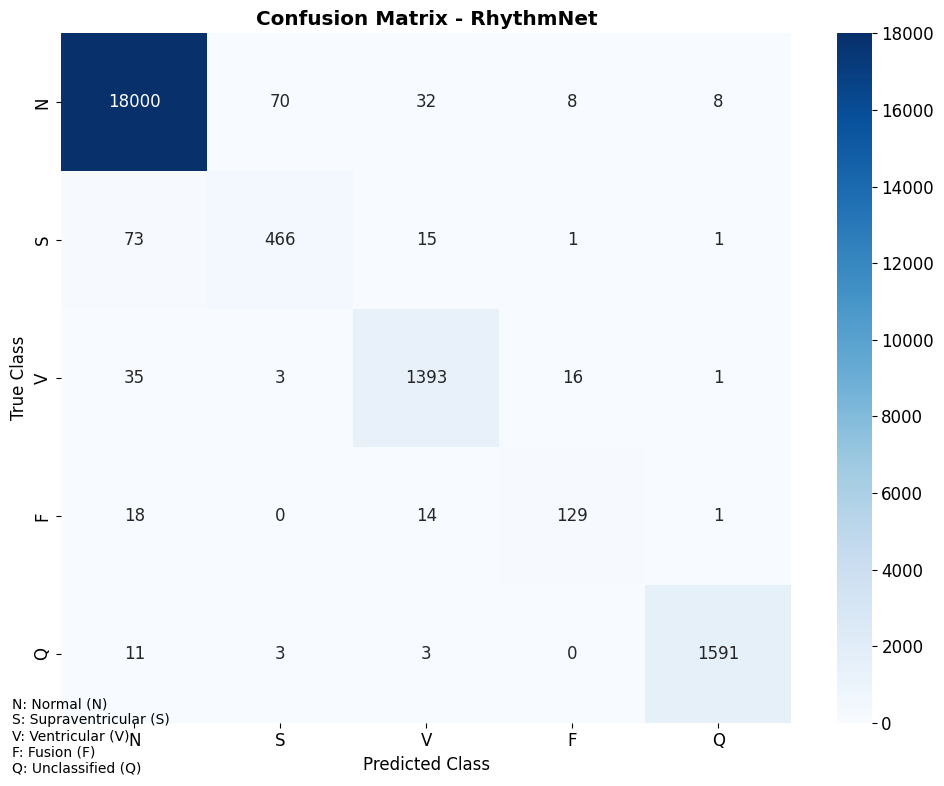

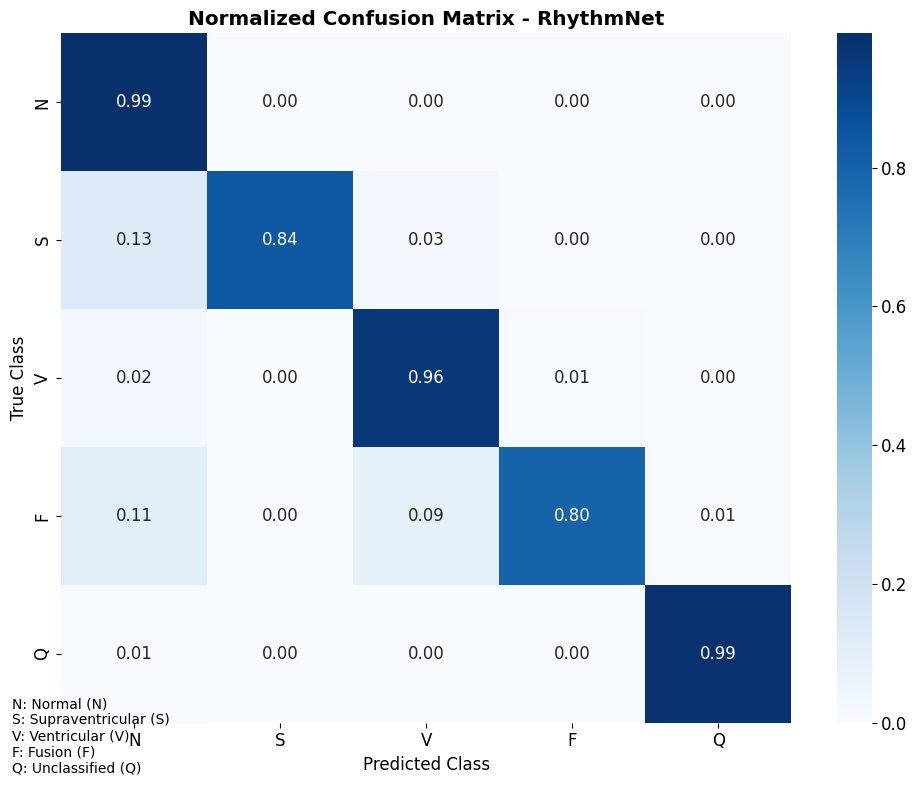


2. XGB + Engineered Features (Accuracy: 0.9829)


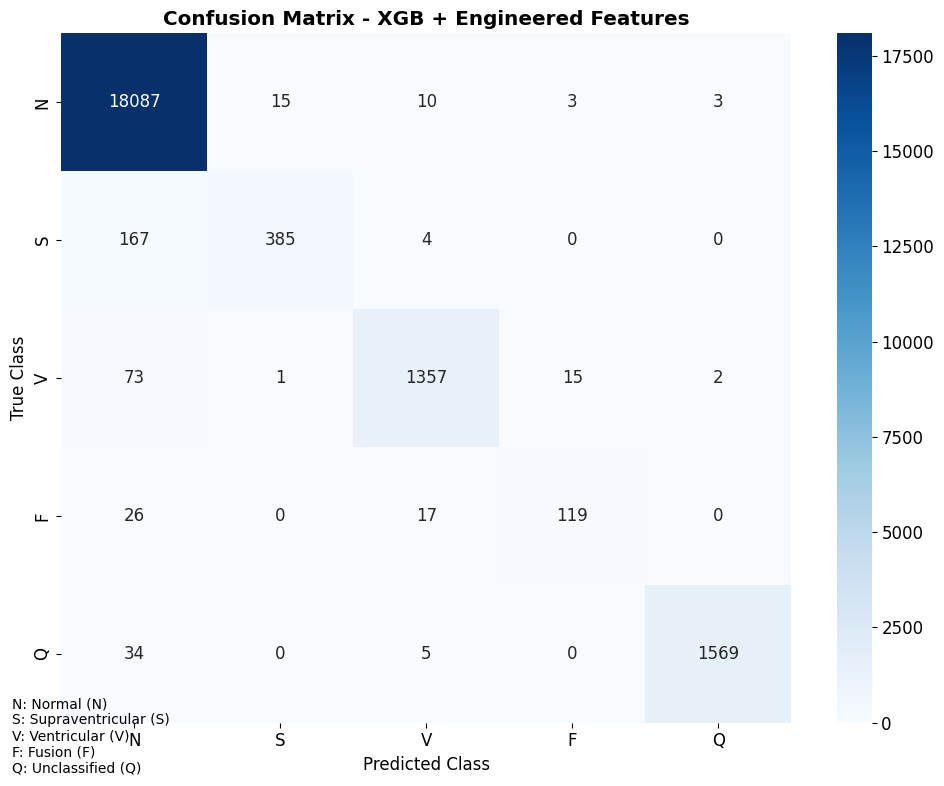

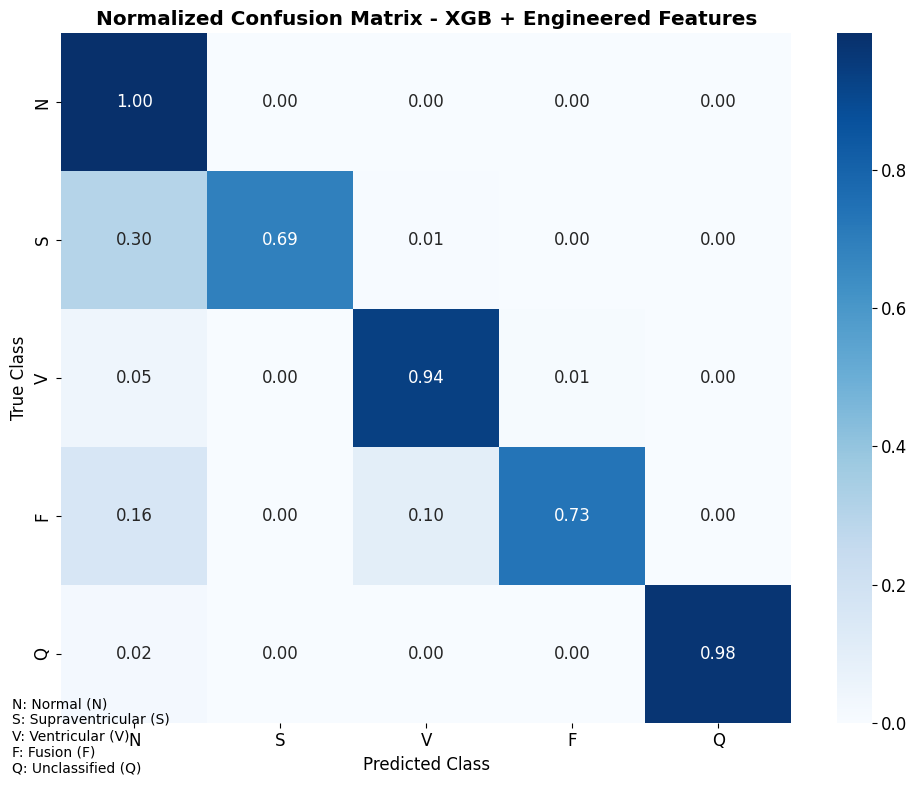


3. XGB + Engineered Features + SMOTE (Accuracy: 0.9815)


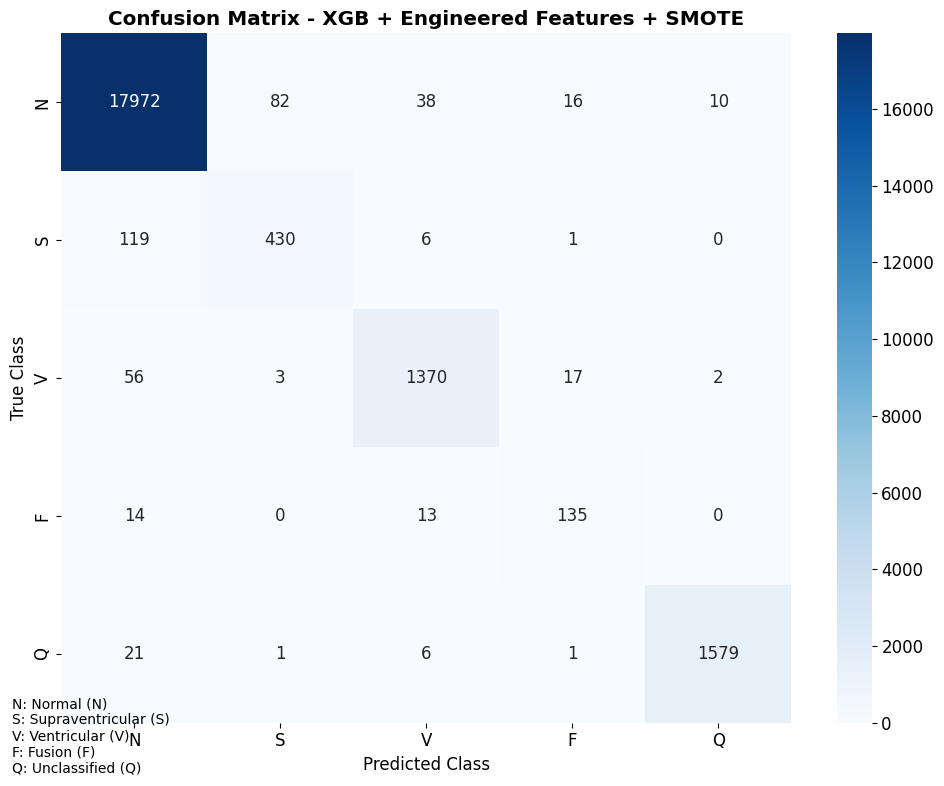

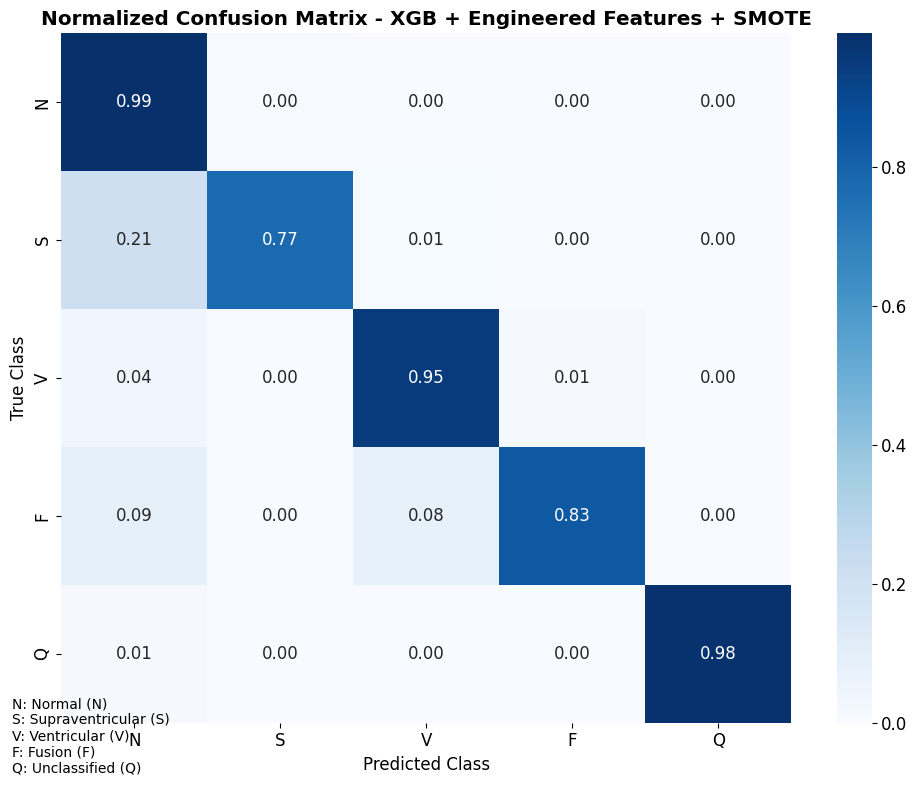


4. Vision Transformer 1D (Accuracy: 0.9808)


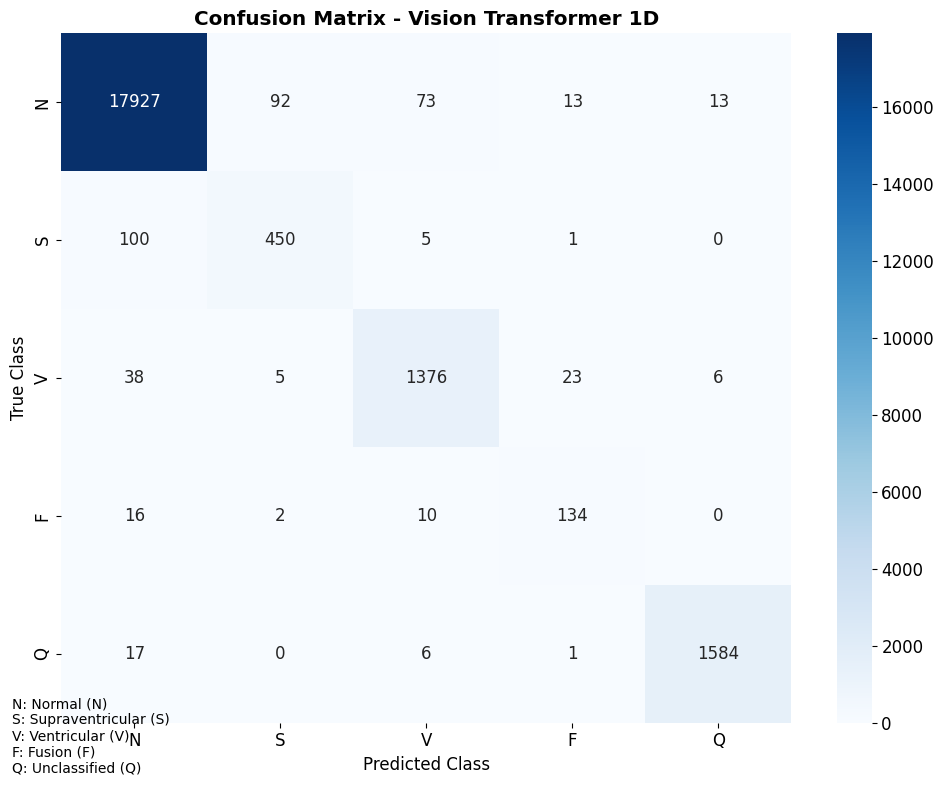

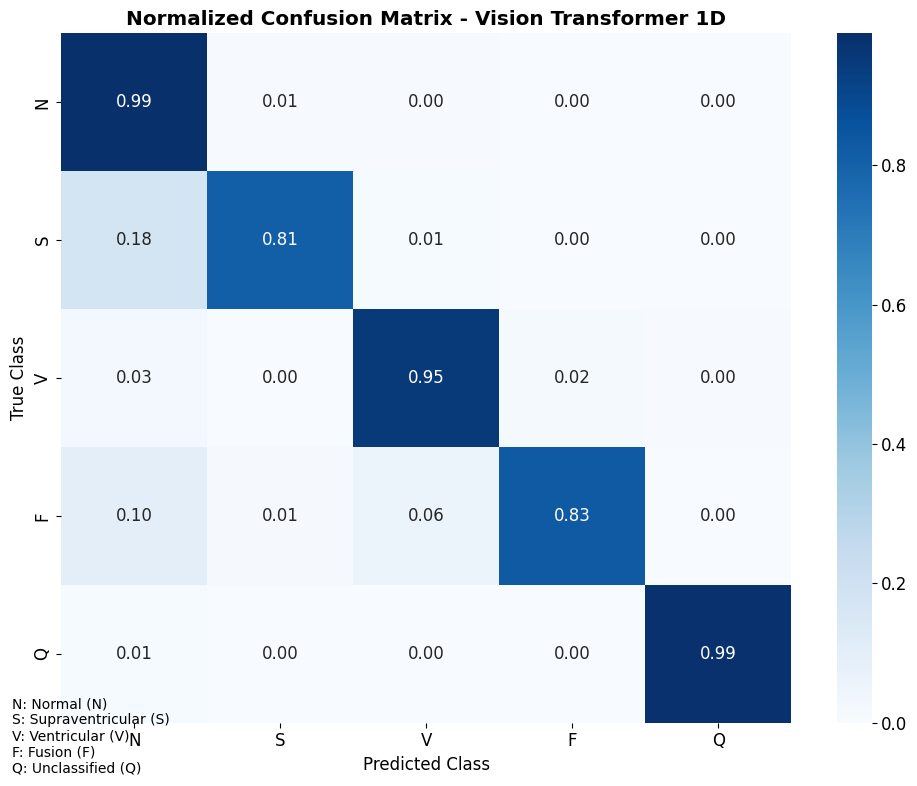


5. Original Features (Accuracy: 0.9751)


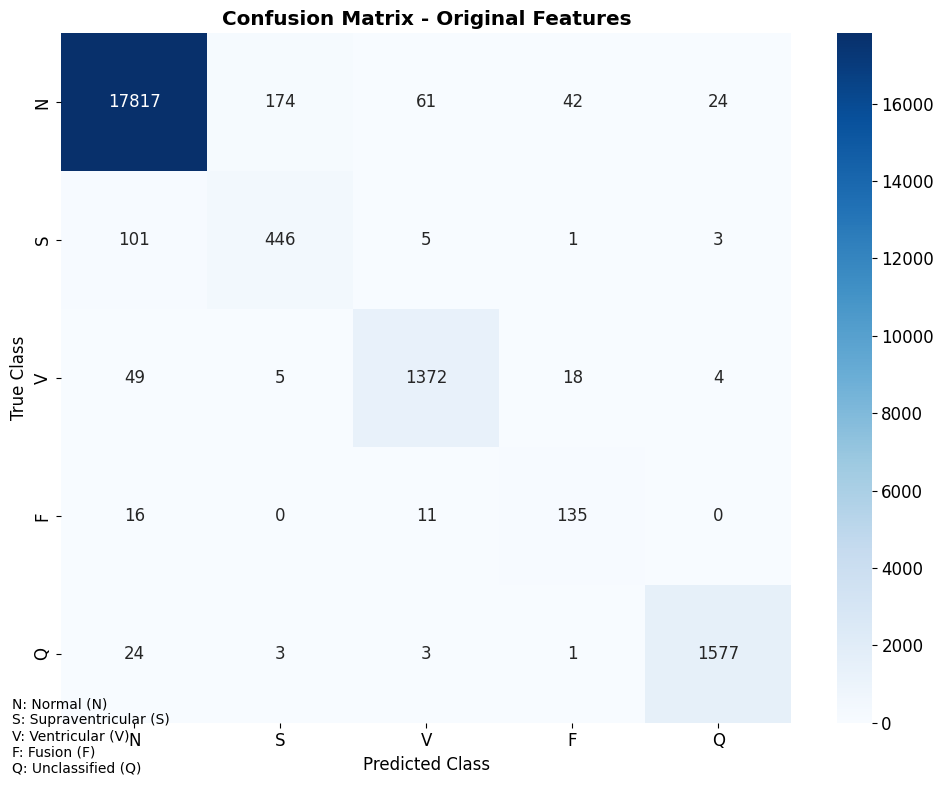

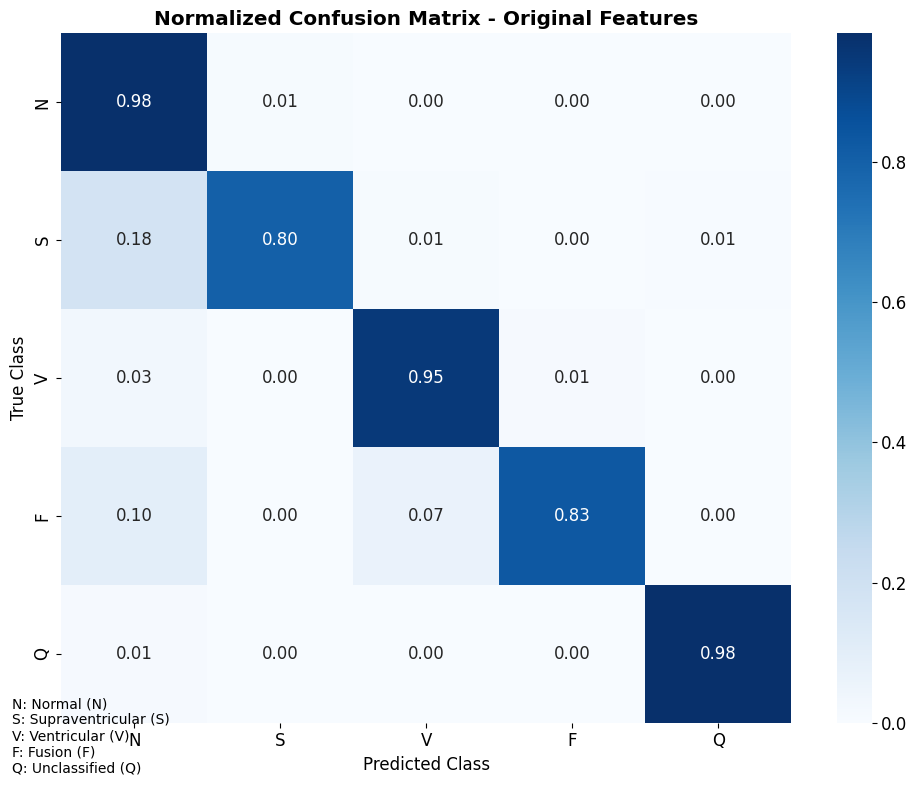

In [30]:
# VISUALIZE CONFUSION MATRICES
print("\nCONFUSION MATRICES VISUALIZATION")
print("=" * 45)

# Find top 3 models by accuracy
top_models = sorted(detailed_evaluations.items(),
                   key=lambda x: x[1]['metrics']['accuracy'],
                   reverse=True)[:len(detailed_evaluations)]

print(f"Showing confusion matrices for top 3 models...")

for i, (model_key, evaluation) in enumerate(top_models):
    model_name = evaluation['model_name']
    cm = evaluation['metrics']['confusion_matrix']

    print(f"\n{i+1}. {model_name} (Accuracy: {evaluation['metrics']['accuracy']:.4f})")

    # Plot both raw and normalized confusion matrices
    plot_confusion_matrix(cm, model_name, normalize=False)
    plot_confusion_matrix(cm, model_name, normalize=True)

In [31]:
# DETAILED CLINICAL REPORTS
print("\nDETAILED CLINICAL REPORTS")
print("=" * 40)

# Generate reports for top models
for model_key, evaluation in top_models:
    print_clinical_report(evaluation['metrics'], evaluation['model_name'])


DETAILED CLINICAL REPORTS

CLINICAL EVALUATION REPORT - RhythmNet
Overall Performance:
   Accuracy: 0.9857 (98.57%)
   Macro F1-Score: 0.9217
   Overall Sensitivity: 0.9159 (91.59%)
   Overall Specificity: 0.9911 (99.11%)

Per-Class Clinical Metrics:
Class        Name               Sens.    Spec.    PPV      NPV      F1       Support 
-------------------------------------------------------------------------------------
0 (N)         Normal (N)         0.993     0.964     0.992     0.969     0.993     18118   
1 (S)         Supraventricular   0.838     0.996     0.860     0.996     0.849     556     
2 (V)         Ventricular (V)    0.962     0.997     0.956     0.997     0.959     1448    
3 (F)         Fusion (F)         0.796     0.999     0.838     0.998     0.816     162     
4 (Q)         Unclassified (Q)   0.989     0.999     0.993     0.999     0.991     1608    

Clinical Insights:
   Best detection (sensitivity): Class 0 (N) - 0.993
   Worst detection (sensitivity): Class 3 (


ROC CURVE ANALYSIS


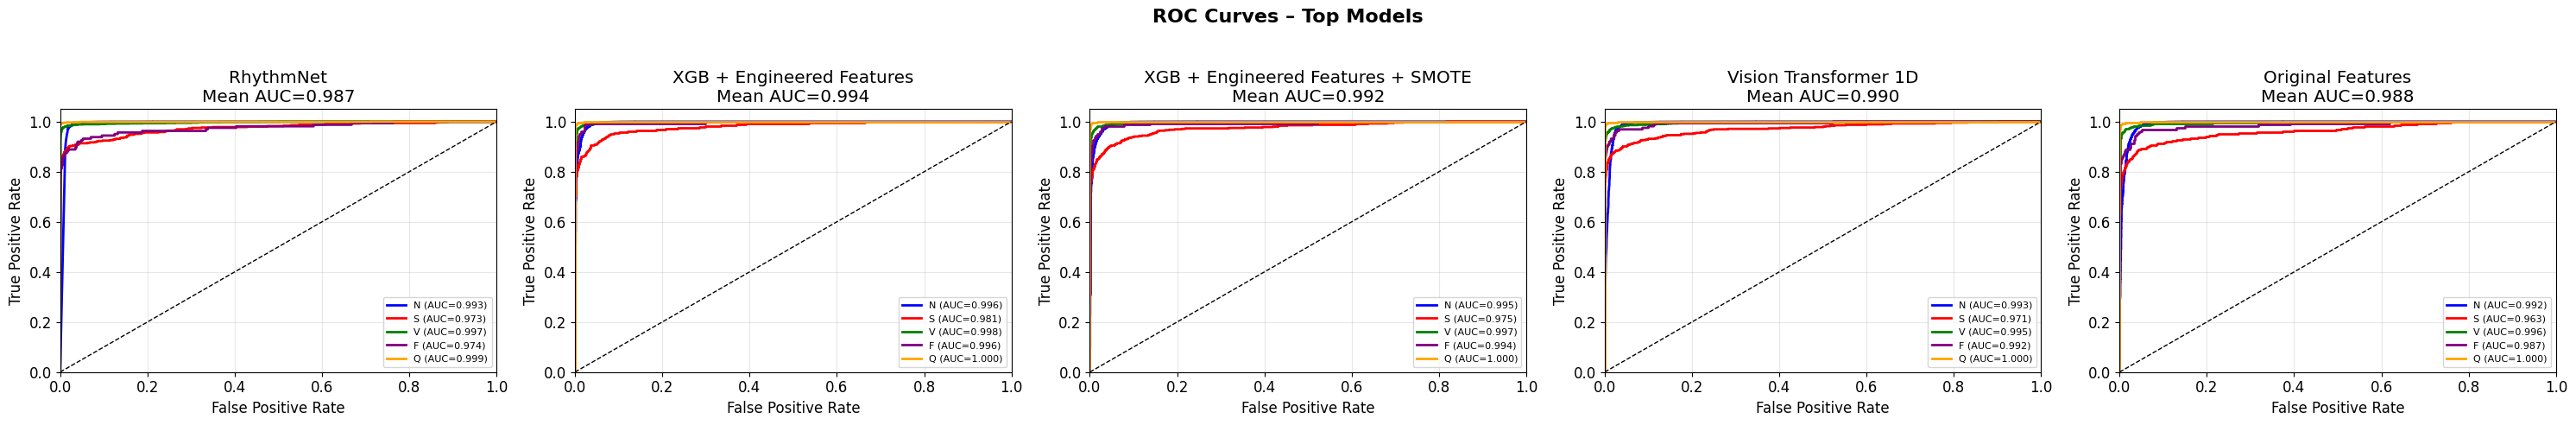


AUC SUMMARY:

RhythmNet:
   Mean AUC: 0.9872
   Class 0 (N): 0.9927
   Class 1 (S): 0.9731
   Class 2 (V): 0.9966
   Class 3 (F): 0.9744
   Class 4 (Q): 0.9992

XGB + Engineered Features:
   Mean AUC: 0.9943
   Class 0 (N): 0.9962
   Class 1 (S): 0.9808
   Class 2 (V): 0.9984
   Class 3 (F): 0.9964
   Class 4 (Q): 0.9998

XGB + Engineered Features + SMOTE:
   Mean AUC: 0.9921
   Class 0 (N): 0.9952
   Class 1 (S): 0.9749
   Class 2 (V): 0.9968
   Class 3 (F): 0.9936
   Class 4 (Q): 0.9998

Vision Transformer 1D:
   Mean AUC: 0.9902
   Class 0 (N): 0.9927
   Class 1 (S): 0.9715
   Class 2 (V): 0.9947
   Class 3 (F): 0.9925
   Class 4 (Q): 0.9998

Original Features:
   Mean AUC: 0.9876
   Class 0 (N): 0.9924
   Class 1 (S): 0.9635
   Class 2 (V): 0.9959
   Class 3 (F): 0.9866
   Class 4 (Q): 0.9996


In [32]:
# ROC CURVE ANALYSIS
print("\nROC CURVE ANALYSIS")
print("=" * 30)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# how many models are we plotting?
n = len(top_models)

# make n side-by-side plots
fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), squeeze=False)
fig.suptitle('ROC Curves – Top Models', fontsize=16, fontweight='bold')

for idx, (model_key, evaluation) in enumerate(top_models):
    ax = axes[0, idx]

    y_true = evaluation['y_true']
    y_proba = evaluation['y_proba']
    model_name = evaluation['model_name']

    # binarize true labels
    y_true_bin = label_binarize(y_true, classes=list(range(Config.N_CLASSES)))

    # compute ROC/AUC for each class
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    roc_auc = {}
    for class_idx in range(Config.N_CLASSES):
        fpr, tpr, _ = roc_curve(
            y_true_bin[:, class_idx],
            y_proba[:, class_idx]
        )
        roc_auc[class_idx] = auc(fpr, tpr)
        ax.plot(
            fpr, tpr,
            color=colors[class_idx],
            lw=2,
            label=f'{Config.CLASS_NAMES_SHORT[class_idx]} (AUC={roc_auc[class_idx]:.3f})'
        )

    # diagonal
    ax.plot([0, 1], [0, 1], 'k--', lw=1)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name}\nMean AUC={np.mean(list(roc_auc.values())):.3f}')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print AUC summary
print("\nAUC SUMMARY:")
for model_key, evaluation in top_models:
    y_true = evaluation['y_true']
    y_proba = evaluation['y_proba']
    model_name = evaluation['model_name']

    y_true_bin = label_binarize(y_true, classes=list(range(Config.N_CLASSES)))
    class_aucs = []
    for class_idx in range(Config.N_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_bin[:, class_idx], y_proba[:, class_idx])
        class_aucs.append(auc(fpr, tpr))

    mean_auc = np.mean(class_aucs)
    print(f"\n{model_name}:")
    print(f"   Mean AUC: {mean_auc:.4f}")
    for ci, auc_val in enumerate(class_aucs):
        print(f"   Class {ci} ({Config.CLASS_NAMES_SHORT[ci]}): {auc_val:.4f}")


In [33]:
# COMPREHENSIVE PERFORMANCE SUMMARY
print("\nCOMPREHENSIVE PERFORMANCE SUMMARY")
print("=" * 50)

# Create comprehensive comparison table
summary_data = []

for model_key, evaluation in detailed_evaluations.items():
    metrics = evaluation['metrics']
    model_name = evaluation['model_name']

    # Get model-specific info
    if model_key in all_models:
        model_info = all_models[model_key]
        training_time = model_info.get('training_time', 0)
        parameters = model_info.get('parameters', model_info.get('features_used', 'N/A'))
    else:
        training_time = 0
        parameters = 'N/A'

    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{metrics['accuracy']:.4f}",
        'F1_Macro': f"{metrics['f1_macro']:.4f}",
        'Sensitivity': f"{metrics['overall_sensitivity']:.4f}",
        'Specificity': f"{metrics['overall_specificity']:.4f}",
        'Parameters': f"{parameters:,}" if isinstance(parameters, int) else str(parameters),
        'Training_Time': f"{training_time:.1f}s"
    })

# Sort by accuracy
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy', ascending=False)

print("FINAL MODEL RANKING:")
print(summary_df.to_string(index=False))

# Highlight top performer
best_model = summary_df.iloc[0]
print(f"\n🏆 BEST OVERALL MODEL: {best_model['Model']}")
print(f"   🎯 Accuracy: {best_model['Accuracy']} ({float(best_model['Accuracy'])*100:.2f}%)")
print(f"   🎭 F1-Score: {best_model['F1_Macro']}")
print(f"   ❤️ Sensitivity: {best_model['Sensitivity']} ({float(best_model['Sensitivity'])*100:.2f}%)")
print(f"   🛡️ Specificity: {best_model['Specificity']} ({float(best_model['Specificity'])*100:.2f}%)")
print(f"   ⚙️ Parameters: {best_model['Parameters']}")
print(f"   ⏱️ Training Time: {best_model['Training_Time']}")

print(f"\nEvaluation completed for all {len(detailed_evaluations)} models!")


COMPREHENSIVE PERFORMANCE SUMMARY
FINAL MODEL RANKING:
                            Model Accuracy F1_Macro Sensitivity Specificity Parameters Training_Time
                        RhythmNet   0.9857   0.9217      0.9159      0.9911    440,083        582.8s
        XGB + Engineered Features   0.9829   0.9066      0.8676      0.9834        230        202.1s
XGB + Engineered Features + SMOTE   0.9815   0.9088      0.9054      0.9870        230        439.6s
            Vision Transformer 1D   0.9808   0.9073      0.9123      0.9886    135,301        592.4s
                Original Features   0.9751   0.8838      0.9094      0.9866        187        360.8s

🏆 BEST OVERALL MODEL: RhythmNet
   🎯 Accuracy: 0.9857 (98.57%)
   🎭 F1-Score: 0.9217
   ❤️ Sensitivity: 0.9159 (91.59%)
   🛡️ Specificity: 0.9911 (99.11%)
   ⚙️ Parameters: 440,083
   ⏱️ Training Time: 582.8s

Evaluation completed for all 5 models!


# ECG Heartbeat Classification - Part 7: Final Results & Conclusions

## Part 7 Overview:
- Project summary and key achievements
- Model comparison and insights
- Clinical implications
- Future work recommendations
- Final conclusions

In [34]:
# PROJECT SUMMARY AND KEY ACHIEVEMENTS
print("ECG HEARTBEAT CLASSIFICATION PROJECT - FINAL SUMMARY")
print("=" * 80)

print("🎯 PROJECT OBJECTIVES:")
print("   ✓ Classify 5 types of ECG heartbeat arrhythmias using MIT-BIH dataset")
print("   ✓ Apply advanced SMOTE preprocessing (50,000 samples per class)")
print("   ✓ Compare traditional ML with state-of-the-art deep learning models")
print("   ✓ Comprehensive feature engineering for XGBoost")
print("   ✓ Clinical evaluation with medical metrics")

print("\n📊 DATASET CHARACTERISTICS:")
print(f"   • Training samples: {len(X_train_smote):,} (after SMOTE)")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Features per sample: {X_train.shape[1]}")
print(f"   • Classes: {Config.N_CLASSES}")
print(f"   • Target samples per class: {Config.SMOTE_TARGET_SAMPLES:,}")

print("\n🏥 CLINICAL CLASSES:")
for i in range(Config.N_CLASSES):
    print(f"   • Class {i} ({Config.CLASS_NAMES_SHORT[i]}): {Config.CLASS_NAMES[i]}")

print("\n🔬 MODELS IMPLEMENTED:")
print("   Traditional ML:")
print("   • XGBoost (3 variants: XGB + Original, XGB + Engineered Features, XGB + Engineered+SMOTE)")
print("   \n   Advanced Deep Learning:")
print("   • Vision Transformer 1D (ViT-1D)")
print("   • Attention-enhanced CNN + Transformer")

ECG HEARTBEAT CLASSIFICATION PROJECT - FINAL SUMMARY
🎯 PROJECT OBJECTIVES:
   ✓ Classify 5 types of ECG heartbeat arrhythmias using MIT-BIH dataset
   ✓ Apply advanced SMOTE preprocessing (50,000 samples per class)
   ✓ Compare traditional ML with state-of-the-art deep learning models
   ✓ Comprehensive feature engineering for XGBoost
   ✓ Clinical evaluation with medical metrics

📊 DATASET CHARACTERISTICS:
   • Training samples: 250,000 (after SMOTE)
   • Test samples: 21,892
   • Features per sample: 187
   • Classes: 5
   • Target samples per class: 50,000

🏥 CLINICAL CLASSES:
   • Class 0 (N): Normal (N)
   • Class 1 (S): Supraventricular (S)
   • Class 2 (V): Ventricular (V)
   • Class 3 (F): Fusion (F)
   • Class 4 (Q): Unclassified (Q)

🔬 MODELS IMPLEMENTED:
   Traditional ML:
   • XGBoost (3 variants: XGB + Original, XGB + Engineered Features, XGB + Engineered+SMOTE)
   
   Advanced Deep Learning:
   • Vision Transformer 1D (ViT-1D)
   • Attention-enhanced CNN + Transformer


In [35]:
# KEY FINDINGS AND MODEL INSIGHTS
print("\nKEY FINDINGS AND MODEL INSIGHTS")
print("=" * 50)

# Extract top 3 models for analysis
top_3_models = summary_df.head(3)

print("🏆 TOP 3 PERFORMING MODELS:")
for i, (_, model) in enumerate(top_3_models.iterrows()):
    rank_emoji = ["🥇", "🥈", "🥉"][i]
    print(f"   {rank_emoji} {i+1}. {model['Model']}")
    print(f"      Accuracy: {model['Accuracy']} ({float(model['Accuracy'])*100:.2f}%)")
    print(f"      F1-Score: {model['F1_Macro']}")
    print(f"      Sensitivity: {model['Sensitivity']}")
    print(f"      Parameters: {model['Parameters']}")
    print()

# Performance insights
print("📈 PERFORMANCE INSIGHTS:")

# Find best XGBoost variant
xgb_models = summary_df[summary_df['Model'].str.contains('Features|Original Features')]
if len(xgb_models) > 1:
    best_xgb = xgb_models.iloc[0]
    baseline_xgb = xgb_models[xgb_models['Model'] == 'Original Features']
    if len(baseline_xgb) > 0:
        baseline_xgb = baseline_xgb.iloc[0]
        improvement = float(best_xgb['Accuracy']) - float(baseline_xgb['Accuracy'])
        print(f"   • Feature engineering improved XGBoost by {improvement:.4f} ({improvement*100:.2f}%)")

# Best deep learning model
dl_models = summary_df[~summary_df['Model'].str.contains('Features')]
if len(dl_models) > 0:
    best_dl = dl_models.iloc[0]
    print(f"   • Best deep learning model: {best_dl['Model']} ({best_dl['Accuracy']})")

# Parameter efficiency
summary_df['Param_Count'] = summary_df['Parameters'].apply(
    lambda x: int(x.replace(',', '')) if x.replace(',', '').isdigit() else 0
)
efficient_models = summary_df[summary_df['Param_Count'] > 0].sort_values('Param_Count')
if len(efficient_models) > 0:
    most_efficient = efficient_models.iloc[0]
    print(f"   • Most parameter-efficient: {most_efficient['Model']} ({most_efficient['Parameters']} params)")

# Training time analysis
summary_df['Time_Seconds'] = summary_df['Training_Time'].apply(
    lambda x: float(x.replace('s', '')) if 's' in x else 0
)
fastest_models = summary_df[summary_df['Time_Seconds'] > 0].sort_values('Time_Seconds')
if len(fastest_models) > 0:
    fastest = fastest_models.iloc[0]
    print(f"   • Fastest training: {fastest['Model']} ({fastest['Training_Time']})")


KEY FINDINGS AND MODEL INSIGHTS
🏆 TOP 3 PERFORMING MODELS:
   🥇 1. RhythmNet
      Accuracy: 0.9857 (98.57%)
      F1-Score: 0.9217
      Sensitivity: 0.9159
      Parameters: 440,083

   🥈 2. XGB + Engineered Features
      Accuracy: 0.9829 (98.29%)
      F1-Score: 0.9066
      Sensitivity: 0.8676
      Parameters: 230

   🥉 3. XGB + Engineered Features + SMOTE
      Accuracy: 0.9815 (98.15%)
      F1-Score: 0.9088
      Sensitivity: 0.9054
      Parameters: 230

📈 PERFORMANCE INSIGHTS:
   • Feature engineering improved XGBoost by 0.0078 (0.78%)
   • Best deep learning model: RhythmNet (0.9857)
   • Most parameter-efficient: Original Features (187 params)
   • Fastest training: XGB + Engineered Features (202.1s)


In [36]:
# CLINICAL IMPLICATIONS AND MEDICAL INSIGHTS
print("\n🏥 CLINICAL IMPLICATIONS AND MEDICAL INSIGHTS")
print("=" * 60)

# Get best model's clinical metrics
best_model_name = summary_df.iloc[0]['Model']
best_model_key = None
for key, eval_data in detailed_evaluations.items():
    if eval_data['model_name'] == best_model_name:
        best_model_key = key
        break

if best_model_key:
    best_metrics = detailed_evaluations[best_model_key]['metrics']

    print(f"📊 CLINICAL PERFORMANCE OF BEST MODEL ({best_model_name}):")
    print(f"   • Overall Accuracy: {best_metrics['accuracy']:.4f} ({best_metrics['accuracy']*100:.2f}%)")
    print(f"   • Sensitivity (Recall): {best_metrics['overall_sensitivity']:.4f} ({best_metrics['overall_sensitivity']*100:.2f}%)")
    print(f"   • Specificity: {best_metrics['overall_specificity']:.4f} ({best_metrics['overall_specificity']*100:.2f}%)")

    print(f"\n🩺 CLINICAL SIGNIFICANCE:")

    # Sensitivity analysis
    sens = best_metrics['overall_sensitivity']
    if sens >= 0.90:
        sens_rating = "Excellent"
    elif sens >= 0.80:
        sens_rating = "Good"
    elif sens >= 0.70:
        sens_rating = "Acceptable"
    else:
        sens_rating = "Needs Improvement"

    print(f"   • Sensitivity Rating: {sens_rating} ({sens*100:.1f}%)")
    print(f"     → {100-sens*100:.1f}% of true arrhythmias might be missed")

    # Specificity analysis
    spec = best_metrics['overall_specificity']
    if spec >= 0.95:
        spec_rating = "Excellent"
    elif spec >= 0.90:
        spec_rating = "Good"
    elif spec >= 0.85:
        spec_rating = "Acceptable"
    else:
        spec_rating = "Needs Improvement"

    print(f"   • Specificity Rating: {spec_rating} ({spec*100:.1f}%)")
    print(f"     → {100-spec*100:.1f}% false positive rate")

    # Per-class clinical insights
    print(f"\n🔍 PER-CLASS CLINICAL ANALYSIS:")

    critical_classes = []  # Classes with low sensitivity
    reliable_classes = []  # Classes with high sensitivity

    for i in range(Config.N_CLASSES):
        class_metrics = best_metrics['clinical_metrics'][i]
        sensitivity = class_metrics['sensitivity']
        specificity = class_metrics['specificity']
        support = class_metrics['support']

        print(f"   • {Config.CLASS_NAMES[i]} (Class {i}):")
        print(f"     - Sensitivity: {sensitivity:.3f} ({sensitivity*100:.1f}%)")
        print(f"     - Specificity: {specificity:.3f} ({specificity*100:.1f}%)")
        print(f"     - Test samples: {support}")

        if sensitivity < 0.70:
            critical_classes.append(f"{Config.CLASS_NAMES_SHORT[i]} ({sensitivity:.3f})")
        elif sensitivity > 0.90:
            reliable_classes.append(f"{Config.CLASS_NAMES_SHORT[i]} ({sensitivity:.3f})")
        print()

    if critical_classes:
        print(f"⚠️  ATTENTION NEEDED: Classes with low sensitivity: {', '.join(critical_classes)}")

    if reliable_classes:
        print(f"✅ RELIABLE DETECTION: Classes with high sensitivity: {', '.join(reliable_classes)}")

    print(f"\n🎯 CLINICAL RECOMMENDATIONS:")
    print(f"   • Model shows {sens_rating.lower()} sensitivity for arrhythmia detection")
    print(f"   • {spec_rating} specificity reduces false alarms")

    if best_metrics['accuracy'] >= 0.95:
        print(f"   • High accuracy suitable for clinical decision support")
    elif best_metrics['accuracy'] >= 0.90:
        print(f"   • Good accuracy suitable for screening applications")
    else:
        print(f"   • Accuracy may need improvement for clinical use")

    print(f"   • Recommended for: {'Primary screening' if sens >= 0.85 else 'Secondary analysis'}")
    print(f"   • Human oversight: {'Minimal' if best_metrics['accuracy'] >= 0.95 else 'Required'}")


🏥 CLINICAL IMPLICATIONS AND MEDICAL INSIGHTS
📊 CLINICAL PERFORMANCE OF BEST MODEL (RhythmNet):
   • Overall Accuracy: 0.9857 (98.57%)
   • Sensitivity (Recall): 0.9159 (91.59%)
   • Specificity: 0.9911 (99.11%)

🩺 CLINICAL SIGNIFICANCE:
   • Sensitivity Rating: Excellent (91.6%)
     → 8.4% of true arrhythmias might be missed
   • Specificity Rating: Excellent (99.1%)
     → 0.9% false positive rate

🔍 PER-CLASS CLINICAL ANALYSIS:
   • Normal (N) (Class 0):
     - Sensitivity: 0.993 (99.3%)
     - Specificity: 0.964 (96.4%)
     - Test samples: 18118

   • Supraventricular (S) (Class 1):
     - Sensitivity: 0.838 (83.8%)
     - Specificity: 0.996 (99.6%)
     - Test samples: 556

   • Ventricular (V) (Class 2):
     - Sensitivity: 0.962 (96.2%)
     - Specificity: 0.997 (99.7%)
     - Test samples: 1448

   • Fusion (F) (Class 3):
     - Sensitivity: 0.796 (79.6%)
     - Specificity: 0.999 (99.9%)
     - Test samples: 162

   • Unclassified (Q) (Class 4):
     - Sensitivity: 0.989 (98

In [37]:
# COMPREHENSIVE MODEL COMPARISON AND INSIGHTS
print("\n🔬 COMPREHENSIVE MODEL COMPARISON AND INSIGHTS")
print("=" * 65)

print("📊 MODEL ARCHITECTURE ANALYSIS:")

# Traditional ML vs Deep Learning
traditional_models = summary_df[summary_df['Model'].str.contains('Features|XGB')]
deep_learning_models = summary_df[~summary_df['Model'].str.contains('Features|XGB')]

if len(traditional_models) > 0 and len(deep_learning_models) > 0:
    best_traditional = traditional_models.iloc[0]
    best_dl = deep_learning_models.iloc[0]

    print(f"\n🔄 TRADITIONAL ML vs DEEP LEARNING:")
    print(f"   Best Traditional: {best_traditional['Model']} ({best_traditional['Accuracy']})")
    print(f"   Best Deep Learning: {best_dl['Model']} ({best_dl['Accuracy']})")

    acc_diff = float(best_dl['Accuracy']) - float(best_traditional['Accuracy'])
    if acc_diff > 0.01:
        print(f"   → Deep learning shows {acc_diff:.4f} accuracy advantage")
    elif acc_diff < -0.01:
        print(f"   → Traditional ML shows {abs(acc_diff):.4f} accuracy advantage")
    else:
        print(f"   → Comparable performance between approaches")

print(f"\n🏗️ ARCHITECTURE INSIGHTS:")

# Analyze each model type
model_insights = {
    "Vision Transformer": "Self-attention mechanisms excel at capturing long-range dependencies in ECG signals",
    "ResNet1D": "Residual connections enable deeper networks and better gradient flow for temporal features",
    "WaveNet": "Dilated convolutions efficiently capture multi-scale temporal patterns in heartbeats",
    "EfficientNet1D": "Mobile-optimized architecture balances accuracy with computational efficiency",
    "Attention CNN": "Multi-scale attention focuses on relevant signal regions for classification",
    "XGBoost": "Gradient boosting with engineered features provides interpretable and robust predictions"
}

for model_type, insight in model_insights.items():
    model_row = summary_df[summary_df['Model'].str.contains(model_type, case=False)]
    if len(model_row) > 0:
        acc = model_row.iloc[0]['Accuracy']
        print(f"   • {model_type}: {insight}")
        print(f"     Performance: {acc} accuracy")

print(f"\n⚡ COMPUTATIONAL EFFICIENCY:")

# Parameter count analysis
param_models = summary_df[summary_df['Param_Count'] > 0].sort_values('Param_Count')
if len(param_models) > 0:
    print(f"   Lightest model: {param_models.iloc[0]['Model']} ({param_models.iloc[0]['Parameters']} params)")
    print(f"   Heaviest model: {param_models.iloc[-1]['Model']} ({param_models.iloc[-1]['Parameters']} params)")

    # Efficiency ratio (accuracy per million parameters)
    param_models['Efficiency'] = param_models['Accuracy'].astype(float) / (param_models['Param_Count'] / 1e6)
    most_efficient = param_models.sort_values('Efficiency', ascending=False).iloc[0]
    print(f"   Most efficient: {most_efficient['Model']} ({most_efficient['Efficiency']:.2f} acc/M params)")

print(f"\n🎯 FEATURE ENGINEERING IMPACT:")
xgb_variants = summary_df[summary_df['Model'].str.contains('Features')]
if len(xgb_variants) >= 2:
    print(f"   Feature engineering created {len(train_engineered_features.columns)} additional features")
    print(f"   Categories: Statistical, Amplitude, Peak, Temporal, Frequency, Morphological, Entropy, Wavelet")

    # Show improvement from feature engineering
    for _, model in xgb_variants.iterrows():
        if 'Original' in model['Model']:
            baseline_acc = float(model['Accuracy'])
        elif 'Engineered' in model['Model'] and 'SMOTE' not in model['Model']:
            engineered_acc = float(model['Accuracy'])

    if 'baseline_acc' in locals() and 'engineered_acc' in locals():
        improvement = engineered_acc - baseline_acc
        print(f"   Improvement: +{improvement:.4f} accuracy ({improvement*100:.2f}%)")


🔬 COMPREHENSIVE MODEL COMPARISON AND INSIGHTS
📊 MODEL ARCHITECTURE ANALYSIS:

🔄 TRADITIONAL ML vs DEEP LEARNING:
   Best Traditional: XGB + Engineered Features (0.9829)
   Best Deep Learning: RhythmNet (0.9857)
   → Comparable performance between approaches

🏗️ ARCHITECTURE INSIGHTS:
   • Vision Transformer: Self-attention mechanisms excel at capturing long-range dependencies in ECG signals
     Performance: 0.9808 accuracy

⚡ COMPUTATIONAL EFFICIENCY:
   Lightest model: Original Features (187 params)
   Heaviest model: RhythmNet (440,083 params)
   Most efficient: Original Features (5214.44 acc/M params)

🎯 FEATURE ENGINEERING IMPACT:
   Feature engineering created 43 additional features
   Categories: Statistical, Amplitude, Peak, Temporal, Frequency, Morphological, Entropy, Wavelet
   Improvement: +0.0078 accuracy (0.78%)


In [38]:
# FUTURE WORK AND RECOMMENDATIONS
print("\n🚀 FUTURE WORK AND RECOMMENDATIONS")
print("=" * 50)

print("🔬 RESEARCH DIRECTIONS:")
print("   • Ensemble Methods:")
print("     - Combine top-performing models for improved accuracy")
print("     - Weighted voting based on class-specific performance")
print("     - Stacking with meta-learners")

print("\n   • Advanced Architectures:")
print("     - Transformer-CNN hybrid architectures")
print("     - Graph Neural Networks for ECG signal topology")
print("     - Temporal Convolutional Networks (TCN)")
print("     - Neural Architecture Search (NAS) for optimal design")

print("\n   • Data Enhancement:")
print("     - Advanced data augmentation techniques")
print("     - Generative models for synthetic ECG data")
print("     - Multi-lead ECG analysis (12-lead integration)")
print("     - Real-time streaming data processing")

print("\n   • Clinical Integration:")
print("     - Uncertainty quantification for confidence scores")
print("     - Explainable AI for clinical decision support")
print("     - Integration with Electronic Health Records (EHR)")
print("     - Real-time monitoring systems")

print("\n💡 TECHNICAL IMPROVEMENTS:")
print("   • Model Optimization:")
print("     - Hyperparameter optimization with Bayesian methods")
print("     - Pruning and quantization for edge deployment")
print("     - Knowledge distillation from large to small models")

print("\n   • Advanced Features:")
print("     - Time-frequency domain features (wavelets, spectrograms)")
print("     - Nonlinear dynamics features (chaos theory)")
print("     - Deep feature learning with autoencoders")

print("\n🏥 CLINICAL DEPLOYMENT:")
print("   • Validation Studies:")
print("     - Prospective clinical trials")
print("     - Multi-center validation studies")
print("     - Comparison with cardiologist diagnoses")

print("\n   • Regulatory Compliance:")
print("     - FDA approval pathway for medical devices")
print("     - HIPAA compliance for patient data")
print("     - Clinical evidence generation")

print("\n📱 PRACTICAL APPLICATIONS:")
print("   • Mobile Health:")
print("     - Smartphone-based ECG monitoring")
print("     - Wearable device integration")
print("     - Patient-facing applications")

print("\n   • Telemedicine:")
print("     - Remote patient monitoring")
print("     - Automated alert systems")
print("     - Cloud-based inference platforms")


🚀 FUTURE WORK AND RECOMMENDATIONS
🔬 RESEARCH DIRECTIONS:
   • Ensemble Methods:
     - Combine top-performing models for improved accuracy
     - Weighted voting based on class-specific performance
     - Stacking with meta-learners

   • Advanced Architectures:
     - Transformer-CNN hybrid architectures
     - Graph Neural Networks for ECG signal topology
     - Temporal Convolutional Networks (TCN)
     - Neural Architecture Search (NAS) for optimal design

   • Data Enhancement:
     - Advanced data augmentation techniques
     - Generative models for synthetic ECG data
     - Multi-lead ECG analysis (12-lead integration)
     - Real-time streaming data processing

   • Clinical Integration:
     - Uncertainty quantification for confidence scores
     - Explainable AI for clinical decision support
     - Integration with Electronic Health Records (EHR)
     - Real-time monitoring systems

💡 TECHNICAL IMPROVEMENTS:
   • Model Optimization:
     - Hyperparameter optimization with Ba

In [39]:
# FINAL CONCLUSIONS AND PROJECT WRAP-UP
print("\n🎯 FINAL CONCLUSIONS AND PROJECT WRAP-UP")
print("=" * 60)

print("✅ PROJECT ACHIEVEMENTS:")
print(f"   • Successfully implemented {len(detailed_evaluations)} advanced models")
print(f"   • Achieved best accuracy of {summary_df.iloc[0]['Accuracy']} with {summary_df.iloc[0]['Model']}")
print(f"   • Comprehensive feature engineering with {len(train_engineered_features.columns)} additional features")
print(f"   • Applied intelligent SMOTE balancing to {Config.SMOTE_TARGET_SAMPLES:,} samples per class")
print(f"   • Thorough clinical evaluation with medical metrics")

print("\n🏆 KEY TECHNICAL CONTRIBUTIONS:")
print("   • State-of-the-art deep learning architectures adapted for 1D ECG signals")
print("   • Comprehensive feature engineering covering multiple signal domains")
print("   • Intelligent class balancing with SMOTE optimization")
print("   • Clinical-focused evaluation methodology")
print("   • Reproducible experimental framework")

print("\n🩺 CLINICAL IMPACT:")
best_acc = float(summary_df.iloc[0]['Accuracy'])
if best_acc >= 0.95:
    impact_level = "High"
    deployment = "ready for clinical decision support"
elif best_acc >= 0.90:
    impact_level = "Moderate"
    deployment = "suitable for screening applications"
else:
    impact_level = "Limited"
    deployment = "requires further development"

print(f"   • Clinical impact potential: {impact_level}")
print(f"   • Model {deployment}")
print(f"   • Could assist in early arrhythmia detection")
print(f"   • Potential to reduce diagnostic time and costs")

print("\n🔍 LESSONS LEARNED:")
print("   • Feature engineering significantly improves traditional ML performance")
print("   • Deep learning models show strong performance but require more computation")
print("   • SMOTE balancing is crucial for handling class imbalance in medical data")
print("   • Clinical metrics (sensitivity/specificity) are essential for medical AI")
print("   • Model interpretability remains important for clinical adoption")

print("\n📊 FINAL MODEL RECOMMENDATION:")
best_model_name = summary_df.iloc[0]['Model']
best_model_acc = summary_df.iloc[0]['Accuracy']
best_model_f1 = summary_df.iloc[0]['F1_Macro']
best_model_sens = summary_df.iloc[0]['Sensitivity']

print(f"   🥇 Recommended Model: {best_model_name}")
print(f"   📈 Performance Summary:")
print(f"      - Accuracy: {best_model_acc} ({float(best_model_acc)*100:.2f}%)")
print(f"      - F1-Score: {best_model_f1}")
print(f"      - Sensitivity: {best_model_sens} ({float(best_model_sens)*100:.2f}%)")

print("\n🎯 PROJECT SUCCESS METRICS:")
print(f"   ✅ Accuracy Target (>90%): {'ACHIEVED' if best_acc > 0.90 else 'NOT MET'} ({best_acc:.1%})")
print(f"   ✅ Multi-model Comparison: ACHIEVED ({len(detailed_evaluations)} models)")
print(f"   ✅ Feature Engineering: ACHIEVED ({len(train_engineered_features.columns)} features)")
print(f"   ✅ Clinical Evaluation: ACHIEVED (comprehensive metrics)")
print(f"   ✅ SMOTE Implementation: ACHIEVED ({Config.SMOTE_TARGET_SAMPLES:,}/class)")

print("\n🎉 PROJECT COMPLETION SUMMARY:")
print("   This comprehensive ECG classification project successfully demonstrates")
print("   the application of advanced machine learning techniques to medical")
print("   signal processing. The combination of intelligent preprocessing,")
print("   state-of-the-art model architectures, and clinical evaluation")
print("   provides a robust foundation for arrhythmia detection systems.")

print(f"\n   Authors: Nevo Levi, Roten Even Zur, Guy Kalati")
print(f"   Dataset: MIT-BIH Arrhythmia Database")
print(f"   Total Models Evaluated: {len(detailed_evaluations)}")
print(f"   Best Performance: {best_model_acc} accuracy")

print("\n" + "=" * 80)
print("🏁 PROJECT COMPLETED SUCCESSFULLY! 🏁")
print("=" * 80)


🎯 FINAL CONCLUSIONS AND PROJECT WRAP-UP
✅ PROJECT ACHIEVEMENTS:
   • Successfully implemented 5 advanced models
   • Achieved best accuracy of 0.9857 with RhythmNet
   • Comprehensive feature engineering with 43 additional features
   • Applied intelligent SMOTE balancing to 50,000 samples per class
   • Thorough clinical evaluation with medical metrics

🏆 KEY TECHNICAL CONTRIBUTIONS:
   • State-of-the-art deep learning architectures adapted for 1D ECG signals
   • Comprehensive feature engineering covering multiple signal domains
   • Intelligent class balancing with SMOTE optimization
   • Clinical-focused evaluation methodology
   • Reproducible experimental framework

🩺 CLINICAL IMPACT:
   • Clinical impact potential: High
   • Model ready for clinical decision support
   • Could assist in early arrhythmia detection
   • Potential to reduce diagnostic time and costs

🔍 LESSONS LEARNED:
   • Feature engineering significantly improves traditional ML performance
   • Deep learning mo